## Imports

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)
torch.manual_seed(42)

<hr>

## Loading Files

In [17]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')

print(X.shape, y.shape)

(20000, 6, 28) (20000,)


In [18]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
print(X_train.shape, X_val.shape)

(16000, 6, 28) (4000, 6, 28)


<hr>

## Dataset Class

In [19]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [20]:
# For evaluation
val_dataset = SimpleDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

<hr>

## Model

In [21]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int, dropout_p=0.5) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )
 
 
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.5):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [22]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

# Initialize and load models
backbone = cnn_dropout()
backbone.to(device)

fc = FC_dropout(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

In [23]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

<hr>

## Evaluation Function

In [24]:
def eval_perf(dataloader, backbone, fc, device):
    backbone.eval()
    fc.eval()

    pred=[]
    gt=[]

    with torch.no_grad():
        for batch in dataloader:
            xt, yt = batch["x"].to(device), batch["y"].to(device)

            # Forward pass through backbone and FC head
            features = backbone(xt)
            outputs = fc(features)
            
            yt_pred = torch.argmax(outputs, dim=1)
            pred.extend(yt_pred.cpu().numpy())
            gt.extend(yt.cpu().numpy())

    # Convert to numpy arrays
    pred = np.array(pred)
    gt = np.array(gt)

    # Computing metrics
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    acc = np.mean(pred == gt)
    avg_f1 = f1s.mean()

    # Set models back to train mode
    backbone.train()
    fc.train()

    return f1s, acc, avg_f1

<hr>

## Query Sampler (Aquisition Functions)

In [40]:
# ============= Predictive Entropy ============= 
def predictive_entropy_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc='MC Dropout Simulations (PredEntropy)'):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                logits.append(F.softmax(out, dim=1).cpu())
            probs = torch.cat(logits, dim=0)
            mc_probs.append(probs)

    mc_probs = torch.stack(mc_probs)  # Shape: [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # Shape: [N, C]
    entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)

    topk = torch.topk(entropy, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BALD (Bayesian AL by Disagreement) ============= 
def bald_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc="MC Dropout Simulations (BALD)"):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                probs = F.softmax(out, dim=1).cpu()
                logits.append(probs)
            mc_probs.append(torch.cat(logits, dim=0))

    mc_probs = torch.stack(mc_probs)  # [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # [N, C]

    # Predictive Entropy
    H = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)  # [N]

    # Expected Entropy
    E_H = -torch.sum(mc_probs * torch.log(mc_probs + 1e-8), dim=2).mean(dim=0)  # [N]

    # BALD = H - E_H
    bald_score = H - E_H
    topk = torch.topk(bald_score, k=k).indices
    return [indices[i.item()] for i in topk]



# ============= Variation Ratios ============= 
def variation_ratio_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    preds = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc="MC Dropout Simulations (VarRatio)"):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                pred = torch.argmax(out, dim=1).cpu()
                logits.append(pred)
            preds.append(torch.cat(logits, dim=0))

    preds = torch.stack(preds)  # [T, N]
    mode_preds = torch.mode(preds, dim=0)[0]  # [N]
    agreement = (preds == mode_preds.unsqueeze(0)).sum(dim=0)  # [N]
    variation_ratio = 1 - agreement.float() / sim

    topk = torch.topk(variation_ratio, k=k).indices
    return [indices[i.item()] for i in topk]

In [63]:
sampling_strategies = {
    "predictive_entropy": predictive_entropy_sampling,
    "bald": bald_sampling,
    "variation_ratio": variation_ratio_sampling,
}

# Create separate pools and histories for each strategy
strategy_pools = {}
strategy_histories = {}

for name in sampling_strategies:
    strategy_pools[name] = {
        "labeled": set(),
        "unlabeled": set(range(len(X_train)))
    }
    
    strategy_histories[name] = {
        "rounds": [],
        "num_labeled": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "val_avg_f1": [],
        "val_f1s": []
    }

<hr>

## Training Loop

In [62]:
def train(backbone, fc, train_loader, device, epochs=5):
    backbone.train()
    fc.train()

    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fc.parameters()), lr=1e-3)
    train_acc_history = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Accuracy calculation
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yt).sum().item()
            total += yt.size(0)

        acc = correct / total
        train_acc_history.append(acc)
            
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Train Acc: {acc*100:.2f}%")

    return train_acc_history

<hr>

## AL Pipeline Loop

In [64]:
num_rounds = 25
query_size = 20
sim = 30

# Calculate total and effective samples
total_samples = num_rounds * query_size
effective_samples = query_size * (num_rounds * (num_rounds + 1)) // 2  # Sum of 1+2+...+num_rounds

# Nicely formatted print
print("=" * 50)
print(" Active Learning Configuration Summary")
print("=" * 50)
print(f"Simulations (sim):          {sim}")
print(f"Number of Rounds:           {num_rounds}")
print(f"Query Size per Round:       {query_size}")
print(f"Total Labeled Samples:      {total_samples}")
print(f"Effective Samples (Total):  {effective_samples}")
print("=" * 50)

 Active Learning Configuration Summary
Simulations (sim):          30
Number of Rounds:           25
Query Size per Round:       20
Total Labeled Samples:      500
Effective Samples (Total):  6500


In [65]:
for name, query_func in sampling_strategies.items():
    print(f"\n======================")
    print(f" Running strategy: {name.upper()} ")
    print(f"======================")    

    labeled_pool = strategy_pools[name]["labeled"]
    unlabeled_pool = strategy_pools[name]["unlabeled"]
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    history = strategy_histories[name]

    for round_num in range(1, num_rounds + 1):
        print(f"\n--- Round {round_num} [{name}] ---")
    
        # Cold start: Re-initialize model at every round
        # backbone = cnn_dropout().to(device)
        # fc = FC_dropout(1024).to(device)
        # backbone.load_state_dict(backbone_state)
        # fc.load_state_dict(fc_state)
        
        # 1. Query k samples
        queried_indices = query_func(
            X=X_train,
            model_backbone=backbone,
            model_fc=fc,
            k=query_size,
            device=device,
            unlabeled_pool=unlabeled_pool,
            sim = sim
        )
    
        # 2. Update pools
        new_indices = set(queried_indices) - labeled_pool  # avoid duplication
        labeled_pool.update(new_indices)
        unlabeled_pool.difference_update(new_indices)
        print('Length of Labeled Pool:', len(labeled_pool))
        print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
        # 3. Build train loader
        train_dataset = SimpleDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
        # 4. Train + Evaluate
        if round_num < 18:
            epochs = min(5 + len(labeled_pool) // 20, 30)
        else:
            epochs = 30
        print("Training Epochs:", epochs)
        
        train_acc = train(backbone, fc, train_loader, device, epochs=epochs)
        val_f1s, val_acc, val_avg_f1 = eval_perf(val_dataloader, backbone, fc, device)
        
        print("Per-class F1 scores:", val_f1s)
        print(f"Overall Accuracy: {val_acc * 100:.2f}%")
        print(f"Average F1 Score: {val_avg_f1:.4f}")
    
        # 5. Update history
        history["rounds"].append(round_num)
        history["num_labeled"].append(len(labeled_pool))
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)
        history["val_avg_f1"].append(val_avg_f1)
        history["val_f1s"].append(val_f1s.tolist())


 Running strategy: PREDICTIVE_ENTROPY 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 16000

--- Round 1 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.03s/it]


Length of Labeled Pool: 20
Length of Unlabeled Pool: 15980
Training Epochs: 6
Epoch 1/6, Loss: 1.9545, Train Acc: 55.00%
Epoch 2/6, Loss: 0.8794, Train Acc: 60.00%
Epoch 3/6, Loss: 1.2722, Train Acc: 65.00%
Epoch 4/6, Loss: 1.0470, Train Acc: 65.00%
Epoch 5/6, Loss: 0.9045, Train Acc: 70.00%
Epoch 6/6, Loss: 0.8014, Train Acc: 65.00%
Per-class F1 scores: [0.88068947 0.89746002 0.8691067 ]
Overall Accuracy: 87.83%
Average F1 Score: 0.8824

--- Round 2 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 40
Length of Unlabeled Pool: 15960
Training Epochs: 7
Epoch 1/7, Loss: 0.9125, Train Acc: 72.50%
Epoch 2/7, Loss: 0.6368, Train Acc: 82.50%
Epoch 3/7, Loss: 2.5828, Train Acc: 62.50%
Epoch 4/7, Loss: 0.4190, Train Acc: 82.50%
Epoch 5/7, Loss: 0.6863, Train Acc: 77.50%
Epoch 6/7, Loss: 1.0127, Train Acc: 77.50%
Epoch 7/7, Loss: 0.9170, Train Acc: 77.50%
Per-class F1 scores: [0.88576159 0.89498581 0.88038566]
Overall Accuracy: 88.48%
Average F1 Score: 0.8870

--- Round 3 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 60
Length of Unlabeled Pool: 15940
Training Epochs: 8
Epoch 1/8, Loss: 0.7631, Train Acc: 68.33%
Epoch 2/8, Loss: 1.0161, Train Acc: 66.67%
Epoch 3/8, Loss: 0.5681, Train Acc: 81.67%
Epoch 4/8, Loss: 0.2750, Train Acc: 90.00%
Epoch 5/8, Loss: 0.3646, Train Acc: 76.67%
Epoch 6/8, Loss: 0.4432, Train Acc: 85.00%
Epoch 7/8, Loss: 0.3255, Train Acc: 83.33%
Epoch 8/8, Loss: 0.4259, Train Acc: 80.00%
Per-class F1 scores: [0.88249661 0.89056604 0.87680492]
Overall Accuracy: 88.12%
Average F1 Score: 0.8833

--- Round 4 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 80
Length of Unlabeled Pool: 15920
Training Epochs: 9
Epoch 1/9, Loss: 0.5167, Train Acc: 86.25%
Epoch 2/9, Loss: 0.5236, Train Acc: 80.00%
Epoch 3/9, Loss: 0.4965, Train Acc: 85.00%
Epoch 4/9, Loss: 0.3838, Train Acc: 87.50%
Epoch 5/9, Loss: 0.5690, Train Acc: 85.00%
Epoch 6/9, Loss: 0.2954, Train Acc: 88.75%
Epoch 7/9, Loss: 0.2746, Train Acc: 90.00%
Epoch 8/9, Loss: 0.2581, Train Acc: 88.75%
Epoch 9/9, Loss: 0.5684, Train Acc: 87.50%
Per-class F1 scores: [0.88882849 0.89101338 0.88122137]
Overall Accuracy: 88.60%
Average F1 Score: 0.8870

--- Round 5 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 100
Length of Unlabeled Pool: 15900
Training Epochs: 10
Epoch 1/10, Loss: 0.5746, Train Acc: 85.00%
Epoch 2/10, Loss: 0.6475, Train Acc: 87.00%
Epoch 3/10, Loss: 0.4726, Train Acc: 88.00%
Epoch 4/10, Loss: 0.1830, Train Acc: 93.00%
Epoch 5/10, Loss: 0.4364, Train Acc: 82.00%
Epoch 6/10, Loss: 0.5298, Train Acc: 85.00%
Epoch 7/10, Loss: 0.5146, Train Acc: 84.00%
Epoch 8/10, Loss: 0.2893, Train Acc: 89.00%
Epoch 9/10, Loss: 0.1665, Train Acc: 93.00%
Epoch 10/10, Loss: 1.1902, Train Acc: 91.00%
Per-class F1 scores: [0.88044932 0.88700565 0.86902157]
Overall Accuracy: 87.67%
Average F1 Score: 0.8788

--- Round 6 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 120
Length of Unlabeled Pool: 15880
Training Epochs: 11
Epoch 1/11, Loss: 0.4984, Train Acc: 81.67%
Epoch 2/11, Loss: 0.3917, Train Acc: 86.67%
Epoch 3/11, Loss: 0.1785, Train Acc: 96.67%
Epoch 4/11, Loss: 0.4362, Train Acc: 83.33%
Epoch 5/11, Loss: 0.2169, Train Acc: 92.50%
Epoch 6/11, Loss: 0.3840, Train Acc: 85.83%
Epoch 7/11, Loss: 0.2797, Train Acc: 90.00%
Epoch 8/11, Loss: 0.2857, Train Acc: 88.33%
Epoch 9/11, Loss: 0.3211, Train Acc: 87.50%
Epoch 10/11, Loss: 0.3542, Train Acc: 88.33%
Epoch 11/11, Loss: 0.2167, Train Acc: 92.50%
Per-class F1 scores: [0.88901221 0.89035917 0.88316357]
Overall Accuracy: 88.67%
Average F1 Score: 0.8875

--- Round 7 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 140
Length of Unlabeled Pool: 15860
Training Epochs: 12
Epoch 1/12, Loss: 0.3456, Train Acc: 86.43%
Epoch 2/12, Loss: 0.4053, Train Acc: 85.00%
Epoch 3/12, Loss: 0.4769, Train Acc: 85.71%
Epoch 4/12, Loss: 0.3941, Train Acc: 85.00%
Epoch 5/12, Loss: 0.4209, Train Acc: 82.86%
Epoch 6/12, Loss: 0.4830, Train Acc: 85.00%
Epoch 7/12, Loss: 0.3064, Train Acc: 89.29%
Epoch 8/12, Loss: 0.1960, Train Acc: 92.86%
Epoch 9/12, Loss: 0.2749, Train Acc: 90.00%
Epoch 10/12, Loss: 0.2519, Train Acc: 90.00%
Epoch 11/12, Loss: 0.2959, Train Acc: 90.71%
Epoch 12/12, Loss: 0.2316, Train Acc: 93.57%
Per-class F1 scores: [0.849553   0.89168279 0.8115372 ]
Overall Accuracy: 84.05%
Average F1 Score: 0.8509

--- Round 8 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 160
Length of Unlabeled Pool: 15840
Training Epochs: 13
Epoch 1/13, Loss: 0.3311, Train Acc: 86.25%
Epoch 2/13, Loss: 0.2598, Train Acc: 90.00%
Epoch 3/13, Loss: 0.1724, Train Acc: 93.75%
Epoch 4/13, Loss: 0.2532, Train Acc: 91.88%
Epoch 5/13, Loss: 0.2341, Train Acc: 90.62%
Epoch 6/13, Loss: 0.2456, Train Acc: 91.88%
Epoch 7/13, Loss: 0.1978, Train Acc: 94.38%
Epoch 8/13, Loss: 0.1960, Train Acc: 92.50%
Epoch 9/13, Loss: 0.1759, Train Acc: 91.88%
Epoch 10/13, Loss: 0.2091, Train Acc: 91.88%
Epoch 11/13, Loss: 0.1235, Train Acc: 94.38%
Epoch 12/13, Loss: 0.2327, Train Acc: 90.00%
Epoch 13/13, Loss: 0.1587, Train Acc: 95.62%
Per-class F1 scores: [0.8838588  0.88996139 0.86996619]
Overall Accuracy: 87.90%
Average F1 Score: 0.8813

--- Round 9 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 180
Length of Unlabeled Pool: 15820
Training Epochs: 14
Epoch 1/14, Loss: 0.3471, Train Acc: 85.56%
Epoch 2/14, Loss: 0.2201, Train Acc: 91.67%
Epoch 3/14, Loss: 0.1722, Train Acc: 93.89%
Epoch 4/14, Loss: 0.1423, Train Acc: 93.89%
Epoch 5/14, Loss: 0.2073, Train Acc: 93.89%
Epoch 6/14, Loss: 0.1322, Train Acc: 95.56%
Epoch 7/14, Loss: 0.2696, Train Acc: 91.67%
Epoch 8/14, Loss: 0.2643, Train Acc: 89.44%
Epoch 9/14, Loss: 0.2046, Train Acc: 93.33%
Epoch 10/14, Loss: 0.1492, Train Acc: 95.56%
Epoch 11/14, Loss: 0.1886, Train Acc: 92.78%
Epoch 12/14, Loss: 0.1757, Train Acc: 94.44%
Epoch 13/14, Loss: 0.1892, Train Acc: 92.78%
Epoch 14/14, Loss: 0.1345, Train Acc: 95.56%
Per-class F1 scores: [0.88811    0.89365854 0.87752603]
Overall Accuracy: 88.45%
Average F1 Score: 0.8864

--- Round 10 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 200
Length of Unlabeled Pool: 15800
Training Epochs: 15
Epoch 1/15, Loss: 0.2314, Train Acc: 94.00%
Epoch 2/15, Loss: 0.2828, Train Acc: 91.00%
Epoch 3/15, Loss: 0.2159, Train Acc: 92.50%
Epoch 4/15, Loss: 0.1771, Train Acc: 95.50%
Epoch 5/15, Loss: 0.2182, Train Acc: 91.00%
Epoch 6/15, Loss: 0.1975, Train Acc: 91.50%
Epoch 7/15, Loss: 0.1869, Train Acc: 92.50%
Epoch 8/15, Loss: 0.2398, Train Acc: 93.50%
Epoch 9/15, Loss: 0.3314, Train Acc: 91.00%
Epoch 10/15, Loss: 0.2138, Train Acc: 95.00%
Epoch 11/15, Loss: 0.2278, Train Acc: 92.00%
Epoch 12/15, Loss: 0.2359, Train Acc: 91.00%
Epoch 13/15, Loss: 0.2533, Train Acc: 93.50%
Epoch 14/15, Loss: 0.1528, Train Acc: 95.00%
Epoch 15/15, Loss: 0.1642, Train Acc: 94.00%
Per-class F1 scores: [0.88660907 0.88698955 0.87881591]
Overall Accuracy: 88.35%
Average F1 Score: 0.8841

--- Round 11 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 220
Length of Unlabeled Pool: 15780
Training Epochs: 16
Epoch 1/16, Loss: 0.3034, Train Acc: 90.00%
Epoch 2/16, Loss: 0.2541, Train Acc: 91.36%
Epoch 3/16, Loss: 0.2499, Train Acc: 89.55%
Epoch 4/16, Loss: 0.2709, Train Acc: 91.36%
Epoch 5/16, Loss: 0.1964, Train Acc: 91.36%
Epoch 6/16, Loss: 0.2146, Train Acc: 92.73%
Epoch 7/16, Loss: 0.1573, Train Acc: 93.64%
Epoch 8/16, Loss: 0.1891, Train Acc: 93.18%
Epoch 9/16, Loss: 0.1416, Train Acc: 96.36%
Epoch 10/16, Loss: 0.2498, Train Acc: 90.91%
Epoch 11/16, Loss: 0.1492, Train Acc: 94.09%
Epoch 12/16, Loss: 0.1709, Train Acc: 93.18%
Epoch 13/16, Loss: 0.2005, Train Acc: 94.09%
Epoch 14/16, Loss: 0.1342, Train Acc: 95.00%
Epoch 15/16, Loss: 0.1734, Train Acc: 93.18%
Epoch 16/16, Loss: 0.1126, Train Acc: 94.09%
Per-class F1 scores: [0.87919106 0.89212828 0.86523498]
Overall Accuracy: 87.52%
Average F1 Score: 0.8789

--- Round 12 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 240
Length of Unlabeled Pool: 15760
Training Epochs: 17
Epoch 1/17, Loss: 0.2227, Train Acc: 92.50%
Epoch 2/17, Loss: 0.1924, Train Acc: 94.17%
Epoch 3/17, Loss: 0.2028, Train Acc: 94.17%
Epoch 4/17, Loss: 0.2244, Train Acc: 91.67%
Epoch 5/17, Loss: 0.2201, Train Acc: 90.83%
Epoch 6/17, Loss: 0.1435, Train Acc: 93.75%
Epoch 7/17, Loss: 0.1858, Train Acc: 92.92%
Epoch 8/17, Loss: 0.1980, Train Acc: 92.50%
Epoch 9/17, Loss: 0.1929, Train Acc: 91.67%
Epoch 10/17, Loss: 0.2835, Train Acc: 91.25%
Epoch 11/17, Loss: 0.1473, Train Acc: 94.58%
Epoch 12/17, Loss: 0.2440, Train Acc: 90.83%
Epoch 13/17, Loss: 0.2092, Train Acc: 94.17%
Epoch 14/17, Loss: 0.1274, Train Acc: 95.42%
Epoch 15/17, Loss: 0.1448, Train Acc: 94.58%
Epoch 16/17, Loss: 0.1154, Train Acc: 95.00%
Epoch 17/17, Loss: 0.1717, Train Acc: 92.92%
Per-class F1 scores: [0.88414799 0.89555126 0.87588109]
Overall Accuracy: 88.22%
Average F1 Score: 0.8852

--- Round 13 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 260
Length of Unlabeled Pool: 15740
Training Epochs: 18
Epoch 1/18, Loss: 0.2693, Train Acc: 93.08%
Epoch 2/18, Loss: 0.2121, Train Acc: 91.92%
Epoch 3/18, Loss: 0.2135, Train Acc: 92.31%
Epoch 4/18, Loss: 0.3592, Train Acc: 92.31%
Epoch 5/18, Loss: 0.5996, Train Acc: 93.46%
Epoch 6/18, Loss: 0.3616, Train Acc: 91.92%
Epoch 7/18, Loss: 0.5105, Train Acc: 90.77%
Epoch 8/18, Loss: 0.3262, Train Acc: 93.08%
Epoch 9/18, Loss: 0.3433, Train Acc: 90.38%
Epoch 10/18, Loss: 0.1940, Train Acc: 94.23%
Epoch 11/18, Loss: 0.2984, Train Acc: 92.69%
Epoch 12/18, Loss: 0.2051, Train Acc: 93.08%
Epoch 13/18, Loss: 0.1774, Train Acc: 93.46%
Epoch 14/18, Loss: 0.2507, Train Acc: 93.08%
Epoch 15/18, Loss: 0.1585, Train Acc: 94.62%
Epoch 16/18, Loss: 0.1864, Train Acc: 92.69%
Epoch 17/18, Loss: 0.1495, Train Acc: 94.23%
Epoch 18/18, Loss: 0.1649, Train Acc: 93.08%
Per-class F1 scores: [0.88379617 0.88994307 0.8742663 ]
Overall Accuracy: 88.08%
Average F1 Score: 0.8827

--- Round 14

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 280
Length of Unlabeled Pool: 15720
Training Epochs: 19
Epoch 1/19, Loss: 0.2467, Train Acc: 91.07%
Epoch 2/19, Loss: 0.1986, Train Acc: 92.14%
Epoch 3/19, Loss: 0.1960, Train Acc: 93.57%
Epoch 4/19, Loss: 0.2213, Train Acc: 91.43%
Epoch 5/19, Loss: 0.1922, Train Acc: 91.79%
Epoch 6/19, Loss: 0.1722, Train Acc: 94.29%
Epoch 7/19, Loss: 0.1990, Train Acc: 93.57%
Epoch 8/19, Loss: 0.2213, Train Acc: 90.71%
Epoch 9/19, Loss: 0.1051, Train Acc: 96.79%
Epoch 10/19, Loss: 0.1940, Train Acc: 92.50%
Epoch 11/19, Loss: 0.0853, Train Acc: 96.79%
Epoch 12/19, Loss: 0.1700, Train Acc: 92.86%
Epoch 13/19, Loss: 0.1856, Train Acc: 93.93%
Epoch 14/19, Loss: 0.1695, Train Acc: 93.21%
Epoch 15/19, Loss: 0.1570, Train Acc: 94.64%
Epoch 16/19, Loss: 0.1410, Train Acc: 95.00%
Epoch 17/19, Loss: 0.1268, Train Acc: 95.71%
Epoch 18/19, Loss: 0.1710, Train Acc: 93.57%
Epoch 19/19, Loss: 0.1641, Train Acc: 93.93%
Per-class F1 scores: [0.87806177 0.88995215 0.86339481]
Overall Accuracy: 

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 300
Length of Unlabeled Pool: 15700
Training Epochs: 20
Epoch 1/20, Loss: 0.2717, Train Acc: 90.33%
Epoch 2/20, Loss: 0.1675, Train Acc: 94.33%
Epoch 3/20, Loss: 0.1827, Train Acc: 94.33%
Epoch 4/20, Loss: 0.2486, Train Acc: 90.33%
Epoch 5/20, Loss: 0.2310, Train Acc: 91.33%
Epoch 6/20, Loss: 0.1876, Train Acc: 94.33%
Epoch 7/20, Loss: 0.1644, Train Acc: 95.00%
Epoch 8/20, Loss: 0.1250, Train Acc: 96.00%
Epoch 9/20, Loss: 0.1748, Train Acc: 92.33%
Epoch 10/20, Loss: 0.1589, Train Acc: 94.33%
Epoch 11/20, Loss: 0.1555, Train Acc: 94.33%
Epoch 12/20, Loss: 0.1460, Train Acc: 94.00%
Epoch 13/20, Loss: 0.1371, Train Acc: 94.67%
Epoch 14/20, Loss: 0.1610, Train Acc: 93.67%
Epoch 15/20, Loss: 0.2073, Train Acc: 93.67%
Epoch 16/20, Loss: 0.2308, Train Acc: 92.00%
Epoch 17/20, Loss: 0.0982, Train Acc: 96.67%
Epoch 18/20, Loss: 0.1664, Train Acc: 94.00%
Epoch 19/20, Loss: 0.1836, Train Acc: 95.33%
Epoch 20/20, Loss: 0.0680, Train Acc: 98.33%
Per-class F1 scores: [0.89008

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 320
Length of Unlabeled Pool: 15680
Training Epochs: 21
Epoch 1/21, Loss: 0.2206, Train Acc: 92.19%
Epoch 2/21, Loss: 0.1892, Train Acc: 94.06%
Epoch 3/21, Loss: 0.2144, Train Acc: 92.50%
Epoch 4/21, Loss: 0.2301, Train Acc: 92.81%
Epoch 5/21, Loss: 0.2178, Train Acc: 94.38%
Epoch 6/21, Loss: 0.1398, Train Acc: 94.38%
Epoch 7/21, Loss: 0.2207, Train Acc: 92.81%
Epoch 8/21, Loss: 0.1997, Train Acc: 93.12%
Epoch 9/21, Loss: 0.1557, Train Acc: 95.31%
Epoch 10/21, Loss: 0.1606, Train Acc: 94.69%
Epoch 11/21, Loss: 0.1273, Train Acc: 96.25%
Epoch 12/21, Loss: 0.1139, Train Acc: 95.31%
Epoch 13/21, Loss: 0.1790, Train Acc: 92.50%
Epoch 14/21, Loss: 0.2039, Train Acc: 92.50%
Epoch 15/21, Loss: 0.1525, Train Acc: 94.06%
Epoch 16/21, Loss: 0.1195, Train Acc: 95.62%
Epoch 17/21, Loss: 0.1033, Train Acc: 96.25%
Epoch 18/21, Loss: 0.2092, Train Acc: 92.81%
Epoch 19/21, Loss: 0.1312, Train Acc: 95.62%
Epoch 20/21, Loss: 0.1358, Train Acc: 96.56%
Epoch 21/21, Loss: 0.1313, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 340
Length of Unlabeled Pool: 15660
Training Epochs: 22
Epoch 1/22, Loss: 0.1853, Train Acc: 93.53%
Epoch 2/22, Loss: 0.2051, Train Acc: 92.94%
Epoch 3/22, Loss: 0.1311, Train Acc: 95.59%
Epoch 4/22, Loss: 0.1233, Train Acc: 96.47%
Epoch 5/22, Loss: 0.1326, Train Acc: 95.00%
Epoch 6/22, Loss: 0.0844, Train Acc: 96.47%
Epoch 7/22, Loss: 0.1549, Train Acc: 94.71%
Epoch 8/22, Loss: 0.1427, Train Acc: 94.41%
Epoch 9/22, Loss: 0.1463, Train Acc: 95.59%
Epoch 10/22, Loss: 0.1495, Train Acc: 95.59%
Epoch 11/22, Loss: 0.1270, Train Acc: 94.71%
Epoch 12/22, Loss: 0.1972, Train Acc: 94.41%
Epoch 13/22, Loss: 0.1598, Train Acc: 95.88%
Epoch 14/22, Loss: 0.2089, Train Acc: 94.12%
Epoch 15/22, Loss: 0.1475, Train Acc: 94.41%
Epoch 16/22, Loss: 0.1521, Train Acc: 93.24%
Epoch 17/22, Loss: 0.1662, Train Acc: 94.71%
Epoch 18/22, Loss: 0.1301, Train Acc: 94.12%
Epoch 19/22, Loss: 0.1226, Train Acc: 95.59%
Epoch 20/22, Loss: 0.1385, Train Acc: 95.59%
Epoch 21/22, Loss: 0.1624, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 360
Length of Unlabeled Pool: 15640
Training Epochs: 30
Epoch 1/30, Loss: 0.2559, Train Acc: 91.67%
Epoch 2/30, Loss: 0.2047, Train Acc: 92.50%
Epoch 3/30, Loss: 0.2577, Train Acc: 91.11%
Epoch 4/30, Loss: 0.1597, Train Acc: 95.28%
Epoch 5/30, Loss: 0.1770, Train Acc: 95.28%
Epoch 6/30, Loss: 0.1901, Train Acc: 95.28%
Epoch 7/30, Loss: 0.1821, Train Acc: 95.28%
Epoch 8/30, Loss: 0.2590, Train Acc: 96.67%
Epoch 9/30, Loss: 0.1716, Train Acc: 94.72%
Epoch 10/30, Loss: 0.1933, Train Acc: 94.17%
Epoch 11/30, Loss: 0.2488, Train Acc: 94.17%
Epoch 12/30, Loss: 0.1658, Train Acc: 95.56%
Epoch 13/30, Loss: 0.2113, Train Acc: 93.61%
Epoch 14/30, Loss: 0.1168, Train Acc: 96.39%
Epoch 15/30, Loss: 0.1130, Train Acc: 95.00%
Epoch 16/30, Loss: 0.2095, Train Acc: 96.11%
Epoch 17/30, Loss: 0.1764, Train Acc: 95.56%
Epoch 18/30, Loss: 0.1468, Train Acc: 95.00%
Epoch 19/30, Loss: 0.1172, Train Acc: 95.83%
Epoch 20/30, Loss: 0.2417, Train Acc: 93.89%
Epoch 21/30, Loss: 0.2174, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 380
Length of Unlabeled Pool: 15620
Training Epochs: 30
Epoch 1/30, Loss: 0.2050, Train Acc: 93.68%
Epoch 2/30, Loss: 0.1696, Train Acc: 94.74%
Epoch 3/30, Loss: 0.1751, Train Acc: 93.95%
Epoch 4/30, Loss: 0.1445, Train Acc: 95.79%
Epoch 5/30, Loss: 0.1603, Train Acc: 94.21%
Epoch 6/30, Loss: 0.1109, Train Acc: 96.58%
Epoch 7/30, Loss: 0.1118, Train Acc: 95.79%
Epoch 8/30, Loss: 0.1185, Train Acc: 96.32%
Epoch 9/30, Loss: 0.1343, Train Acc: 95.53%
Epoch 10/30, Loss: 0.1457, Train Acc: 95.00%
Epoch 11/30, Loss: 0.1472, Train Acc: 95.26%
Epoch 12/30, Loss: 0.1578, Train Acc: 93.68%
Epoch 13/30, Loss: 0.1192, Train Acc: 96.05%
Epoch 14/30, Loss: 0.1347, Train Acc: 95.53%
Epoch 15/30, Loss: 0.1212, Train Acc: 95.26%
Epoch 16/30, Loss: 0.1288, Train Acc: 95.79%
Epoch 17/30, Loss: 0.1626, Train Acc: 93.95%
Epoch 18/30, Loss: 0.0825, Train Acc: 96.32%
Epoch 19/30, Loss: 0.1267, Train Acc: 95.26%
Epoch 20/30, Loss: 0.1346, Train Acc: 94.21%
Epoch 21/30, Loss: 0.0969, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 15600
Training Epochs: 30
Epoch 1/30, Loss: 0.1871, Train Acc: 93.25%
Epoch 2/30, Loss: 0.1776, Train Acc: 94.50%
Epoch 3/30, Loss: 0.1701, Train Acc: 96.00%
Epoch 4/30, Loss: 0.1468, Train Acc: 94.25%
Epoch 5/30, Loss: 0.1672, Train Acc: 93.75%
Epoch 6/30, Loss: 0.1097, Train Acc: 95.75%
Epoch 7/30, Loss: 0.1068, Train Acc: 95.50%
Epoch 8/30, Loss: 0.1302, Train Acc: 96.50%
Epoch 9/30, Loss: 0.1203, Train Acc: 95.50%
Epoch 10/30, Loss: 0.1513, Train Acc: 95.50%
Epoch 11/30, Loss: 0.1405, Train Acc: 97.00%
Epoch 12/30, Loss: 0.1121, Train Acc: 95.25%
Epoch 13/30, Loss: 0.0837, Train Acc: 97.75%
Epoch 14/30, Loss: 0.1275, Train Acc: 94.75%
Epoch 15/30, Loss: 0.1062, Train Acc: 95.75%
Epoch 16/30, Loss: 0.1335, Train Acc: 95.75%
Epoch 17/30, Loss: 0.1087, Train Acc: 96.75%
Epoch 18/30, Loss: 0.1661, Train Acc: 95.25%
Epoch 19/30, Loss: 0.1264, Train Acc: 95.75%
Epoch 20/30, Loss: 0.1045, Train Acc: 96.25%
Epoch 21/30, Loss: 0.1630, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 420
Length of Unlabeled Pool: 15580
Training Epochs: 30
Epoch 1/30, Loss: 0.1946, Train Acc: 94.52%
Epoch 2/30, Loss: 0.2416, Train Acc: 97.14%
Epoch 3/30, Loss: 0.2338, Train Acc: 94.76%
Epoch 4/30, Loss: 0.2024, Train Acc: 95.95%
Epoch 5/30, Loss: 0.1770, Train Acc: 92.62%
Epoch 6/30, Loss: 0.1213, Train Acc: 95.24%
Epoch 7/30, Loss: 0.1508, Train Acc: 94.76%
Epoch 8/30, Loss: 0.1891, Train Acc: 94.29%
Epoch 9/30, Loss: 0.3921, Train Acc: 94.05%
Epoch 10/30, Loss: 0.1492, Train Acc: 95.48%
Epoch 11/30, Loss: 0.2105, Train Acc: 93.81%
Epoch 12/30, Loss: 0.1949, Train Acc: 94.76%
Epoch 13/30, Loss: 0.1149, Train Acc: 97.14%
Epoch 14/30, Loss: 0.2025, Train Acc: 95.71%
Epoch 15/30, Loss: 0.1281, Train Acc: 95.00%
Epoch 16/30, Loss: 0.1346, Train Acc: 95.71%
Epoch 17/30, Loss: 0.1134, Train Acc: 96.19%
Epoch 18/30, Loss: 0.1479, Train Acc: 95.48%
Epoch 19/30, Loss: 0.1052, Train Acc: 95.95%
Epoch 20/30, Loss: 0.0678, Train Acc: 98.81%
Epoch 21/30, Loss: 0.1577, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 440
Length of Unlabeled Pool: 15560
Training Epochs: 30
Epoch 1/30, Loss: 0.2661, Train Acc: 93.64%
Epoch 2/30, Loss: 0.1724, Train Acc: 93.18%
Epoch 3/30, Loss: 0.1077, Train Acc: 96.59%
Epoch 4/30, Loss: 0.1336, Train Acc: 95.91%
Epoch 5/30, Loss: 0.1461, Train Acc: 94.32%
Epoch 6/30, Loss: 0.1254, Train Acc: 95.23%
Epoch 7/30, Loss: 0.1295, Train Acc: 95.45%
Epoch 8/30, Loss: 0.1304, Train Acc: 95.23%
Epoch 9/30, Loss: 0.1084, Train Acc: 95.68%
Epoch 10/30, Loss: 0.1460, Train Acc: 96.36%
Epoch 11/30, Loss: 0.1001, Train Acc: 95.91%
Epoch 12/30, Loss: 0.1022, Train Acc: 95.68%
Epoch 13/30, Loss: 0.0963, Train Acc: 96.82%
Epoch 14/30, Loss: 0.0924, Train Acc: 97.27%
Epoch 15/30, Loss: 0.1439, Train Acc: 95.91%
Epoch 16/30, Loss: 0.1191, Train Acc: 95.00%
Epoch 17/30, Loss: 0.0896, Train Acc: 96.82%
Epoch 18/30, Loss: 0.0962, Train Acc: 96.82%
Epoch 19/30, Loss: 0.0830, Train Acc: 96.82%
Epoch 20/30, Loss: 0.1086, Train Acc: 96.59%
Epoch 21/30, Loss: 0.0857, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 460
Length of Unlabeled Pool: 15540
Training Epochs: 30
Epoch 1/30, Loss: 0.1209, Train Acc: 94.78%
Epoch 2/30, Loss: 0.2180, Train Acc: 94.78%
Epoch 3/30, Loss: 0.1292, Train Acc: 95.87%
Epoch 4/30, Loss: 0.0977, Train Acc: 97.17%
Epoch 5/30, Loss: 0.1401, Train Acc: 95.43%
Epoch 6/30, Loss: 0.0924, Train Acc: 96.52%
Epoch 7/30, Loss: 0.1364, Train Acc: 96.52%
Epoch 8/30, Loss: 0.1340, Train Acc: 96.96%
Epoch 9/30, Loss: 0.1254, Train Acc: 95.65%
Epoch 10/30, Loss: 0.1135, Train Acc: 96.09%
Epoch 11/30, Loss: 0.1390, Train Acc: 95.87%
Epoch 12/30, Loss: 0.0755, Train Acc: 98.04%
Epoch 13/30, Loss: 0.0654, Train Acc: 97.61%
Epoch 14/30, Loss: 0.0977, Train Acc: 97.17%
Epoch 15/30, Loss: 0.1048, Train Acc: 96.30%
Epoch 16/30, Loss: 0.1037, Train Acc: 96.74%
Epoch 17/30, Loss: 0.1093, Train Acc: 95.65%
Epoch 18/30, Loss: 0.1776, Train Acc: 94.78%
Epoch 19/30, Loss: 0.1016, Train Acc: 96.96%
Epoch 20/30, Loss: 0.1342, Train Acc: 95.87%
Epoch 21/30, Loss: 0.0914, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 480
Length of Unlabeled Pool: 15520
Training Epochs: 30
Epoch 1/30, Loss: 0.1688, Train Acc: 94.58%
Epoch 2/30, Loss: 0.1093, Train Acc: 97.08%
Epoch 3/30, Loss: 0.1352, Train Acc: 97.29%
Epoch 4/30, Loss: 0.1167, Train Acc: 95.42%
Epoch 5/30, Loss: 0.1251, Train Acc: 96.25%
Epoch 6/30, Loss: 0.1353, Train Acc: 94.58%
Epoch 7/30, Loss: 0.1097, Train Acc: 96.04%
Epoch 8/30, Loss: 0.1136, Train Acc: 95.83%
Epoch 9/30, Loss: 0.1279, Train Acc: 96.46%
Epoch 10/30, Loss: 0.1516, Train Acc: 95.21%
Epoch 11/30, Loss: 0.1649, Train Acc: 95.42%
Epoch 12/30, Loss: 0.1182, Train Acc: 96.04%
Epoch 13/30, Loss: 0.1131, Train Acc: 96.46%
Epoch 14/30, Loss: 0.0845, Train Acc: 96.88%
Epoch 15/30, Loss: 0.1098, Train Acc: 96.04%
Epoch 16/30, Loss: 0.1189, Train Acc: 96.25%
Epoch 17/30, Loss: 0.1077, Train Acc: 96.46%
Epoch 18/30, Loss: 0.1245, Train Acc: 95.00%
Epoch 19/30, Loss: 0.0944, Train Acc: 96.04%
Epoch 20/30, Loss: 0.0694, Train Acc: 97.08%
Epoch 21/30, Loss: 0.0741, Tr

MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 500
Length of Unlabeled Pool: 15500
Training Epochs: 30
Epoch 1/30, Loss: 0.1359, Train Acc: 94.80%
Epoch 2/30, Loss: 0.0725, Train Acc: 96.80%
Epoch 3/30, Loss: 0.1595, Train Acc: 94.80%
Epoch 4/30, Loss: 0.1211, Train Acc: 96.20%
Epoch 5/30, Loss: 0.1224, Train Acc: 95.20%
Epoch 6/30, Loss: 0.1415, Train Acc: 95.80%
Epoch 7/30, Loss: 0.1172, Train Acc: 96.20%
Epoch 8/30, Loss: 0.1208, Train Acc: 94.80%
Epoch 9/30, Loss: 0.1206, Train Acc: 96.80%
Epoch 10/30, Loss: 0.0808, Train Acc: 96.20%
Epoch 11/30, Loss: 0.1281, Train Acc: 95.00%
Epoch 12/30, Loss: 0.1358, Train Acc: 95.00%
Epoch 13/30, Loss: 0.1468, Train Acc: 95.80%
Epoch 14/30, Loss: 0.1303, Train Acc: 95.80%
Epoch 15/30, Loss: 0.0865, Train Acc: 96.60%
Epoch 16/30, Loss: 0.1027, Train Acc: 96.80%
Epoch 17/30, Loss: 0.0845, Train Acc: 97.20%
Epoch 18/30, Loss: 0.1061, Train Acc: 96.40%
Epoch 19/30, Loss: 0.1026, Train Acc: 95.80%
Epoch 20/30, Loss: 0.1195, Train Acc: 95.60%
Epoch 21/30, Loss: 0.1009, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 20
Length of Unlabeled Pool: 15980
Training Epochs: 6
Epoch 1/6, Loss: 1.0792, Train Acc: 70.00%
Epoch 2/6, Loss: 1.2049, Train Acc: 55.00%
Epoch 3/6, Loss: 0.8213, Train Acc: 65.00%
Epoch 4/6, Loss: 1.1196, Train Acc: 60.00%
Epoch 5/6, Loss: 1.3453, Train Acc: 55.00%
Epoch 6/6, Loss: 0.4056, Train Acc: 85.00%
Per-class F1 scores: [0.86675427 0.89715965 0.84877127]
Overall Accuracy: 86.35%
Average F1 Score: 0.8709

--- Round 2 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 40
Length of Unlabeled Pool: 15960
Training Epochs: 7
Epoch 1/7, Loss: 0.8398, Train Acc: 52.50%
Epoch 2/7, Loss: 1.2272, Train Acc: 55.00%
Epoch 3/7, Loss: 1.2841, Train Acc: 60.00%
Epoch 4/7, Loss: 0.7161, Train Acc: 80.00%
Epoch 5/7, Loss: 0.6174, Train Acc: 80.00%
Epoch 6/7, Loss: 0.8922, Train Acc: 80.00%
Epoch 7/7, Loss: 1.0237, Train Acc: 82.50%
Per-class F1 scores: [0.85082579 0.8504772  0.85134726]
Overall Accuracy: 85.10%
Average F1 Score: 0.8509

--- Round 3 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 60
Length of Unlabeled Pool: 15940
Training Epochs: 8
Epoch 1/8, Loss: 0.9226, Train Acc: 71.67%
Epoch 2/8, Loss: 0.7080, Train Acc: 78.33%
Epoch 3/8, Loss: 0.5026, Train Acc: 78.33%
Epoch 4/8, Loss: 0.6663, Train Acc: 78.33%
Epoch 5/8, Loss: 0.4650, Train Acc: 81.67%
Epoch 6/8, Loss: 0.2880, Train Acc: 90.00%
Epoch 7/8, Loss: 0.5462, Train Acc: 83.33%
Epoch 8/8, Loss: 0.4408, Train Acc: 81.67%
Per-class F1 scores: [0.86061588 0.88649706 0.85347985]
Overall Accuracy: 86.10%
Average F1 Score: 0.8669

--- Round 4 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 80
Length of Unlabeled Pool: 15920
Training Epochs: 9
Epoch 1/9, Loss: 0.5315, Train Acc: 85.00%
Epoch 2/9, Loss: 0.4914, Train Acc: 86.25%
Epoch 3/9, Loss: 0.5441, Train Acc: 81.25%
Epoch 4/9, Loss: 0.4903, Train Acc: 78.75%
Epoch 5/9, Loss: 0.2655, Train Acc: 88.75%
Epoch 6/9, Loss: 0.2311, Train Acc: 88.75%
Epoch 7/9, Loss: 0.2299, Train Acc: 90.00%
Epoch 8/9, Loss: 0.5030, Train Acc: 81.25%
Epoch 9/9, Loss: 0.2026, Train Acc: 93.75%
Per-class F1 scores: [0.85606469 0.87848606 0.85027389]
Overall Accuracy: 85.65%
Average F1 Score: 0.8616

--- Round 5 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 100
Length of Unlabeled Pool: 15900
Training Epochs: 10
Epoch 1/10, Loss: 0.6845, Train Acc: 83.00%
Epoch 2/10, Loss: 0.3500, Train Acc: 87.00%
Epoch 3/10, Loss: 0.7651, Train Acc: 91.00%
Epoch 4/10, Loss: 0.2999, Train Acc: 89.00%
Epoch 5/10, Loss: 0.2257, Train Acc: 94.00%
Epoch 6/10, Loss: 0.3296, Train Acc: 86.00%
Epoch 7/10, Loss: 0.5605, Train Acc: 89.00%
Epoch 8/10, Loss: 0.9438, Train Acc: 81.00%
Epoch 9/10, Loss: 0.6601, Train Acc: 91.00%
Epoch 10/10, Loss: 0.3665, Train Acc: 90.00%
Per-class F1 scores: [0.86336218 0.874      0.85283966]
Overall Accuracy: 86.05%
Average F1 Score: 0.8634

--- Round 6 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 120
Length of Unlabeled Pool: 15880
Training Epochs: 11
Epoch 1/11, Loss: 0.4518, Train Acc: 79.17%
Epoch 2/11, Loss: 0.5725, Train Acc: 80.00%
Epoch 3/11, Loss: 0.2376, Train Acc: 90.83%
Epoch 4/11, Loss: 0.2390, Train Acc: 88.33%
Epoch 5/11, Loss: 0.2059, Train Acc: 92.50%
Epoch 6/11, Loss: 0.2037, Train Acc: 94.17%
Epoch 7/11, Loss: 0.1988, Train Acc: 92.50%
Epoch 8/11, Loss: 0.2613, Train Acc: 89.17%
Epoch 9/11, Loss: 0.2710, Train Acc: 90.00%
Epoch 10/11, Loss: 0.2131, Train Acc: 90.83%
Epoch 11/11, Loss: 0.1873, Train Acc: 91.67%
Per-class F1 scores: [0.87593985 0.89126214 0.86568084]
Overall Accuracy: 87.38%
Average F1 Score: 0.8776

--- Round 7 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 140
Length of Unlabeled Pool: 15860
Training Epochs: 12
Epoch 1/12, Loss: 0.3576, Train Acc: 87.14%
Epoch 2/12, Loss: 0.2772, Train Acc: 86.43%
Epoch 3/12, Loss: 0.3809, Train Acc: 87.86%
Epoch 4/12, Loss: 0.2215, Train Acc: 92.86%
Epoch 5/12, Loss: 0.1452, Train Acc: 95.00%
Epoch 6/12, Loss: 0.3632, Train Acc: 87.86%
Epoch 7/12, Loss: 0.2087, Train Acc: 90.71%
Epoch 8/12, Loss: 0.2161, Train Acc: 91.43%
Epoch 9/12, Loss: 0.2132, Train Acc: 90.71%
Epoch 10/12, Loss: 0.2525, Train Acc: 88.57%
Epoch 11/12, Loss: 0.1389, Train Acc: 97.86%
Epoch 12/12, Loss: 0.2421, Train Acc: 90.71%
Per-class F1 scores: [0.88369565 0.89019608 0.87818182]
Overall Accuracy: 88.22%
Average F1 Score: 0.8840

--- Round 8 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 160
Length of Unlabeled Pool: 15840
Training Epochs: 13
Epoch 1/13, Loss: 0.4796, Train Acc: 85.00%
Epoch 2/13, Loss: 0.4685, Train Acc: 90.00%
Epoch 3/13, Loss: 0.1949, Train Acc: 92.50%
Epoch 4/13, Loss: 0.2984, Train Acc: 91.25%
Epoch 5/13, Loss: 0.2637, Train Acc: 91.25%
Epoch 6/13, Loss: 0.1475, Train Acc: 93.12%
Epoch 7/13, Loss: 0.2113, Train Acc: 91.88%
Epoch 8/13, Loss: 0.1597, Train Acc: 95.62%
Epoch 9/13, Loss: 0.2995, Train Acc: 89.38%
Epoch 10/13, Loss: 0.2192, Train Acc: 90.62%
Epoch 11/13, Loss: 0.1201, Train Acc: 95.62%
Epoch 12/13, Loss: 0.1860, Train Acc: 95.00%
Epoch 13/13, Loss: 0.1722, Train Acc: 93.12%
Per-class F1 scores: [0.87986558 0.89566929 0.87664811]
Overall Accuracy: 88.05%
Average F1 Score: 0.8841

--- Round 9 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 180
Length of Unlabeled Pool: 15820
Training Epochs: 14
Epoch 1/14, Loss: 0.3008, Train Acc: 89.44%
Epoch 2/14, Loss: 0.2047, Train Acc: 91.67%
Epoch 3/14, Loss: 0.2325, Train Acc: 93.33%
Epoch 4/14, Loss: 0.1723, Train Acc: 93.33%
Epoch 5/14, Loss: 0.1947, Train Acc: 92.22%
Epoch 6/14, Loss: 0.1636, Train Acc: 93.33%
Epoch 7/14, Loss: 0.1656, Train Acc: 93.33%
Epoch 8/14, Loss: 0.1906, Train Acc: 93.89%
Epoch 9/14, Loss: 0.2099, Train Acc: 91.11%
Epoch 10/14, Loss: 0.1742, Train Acc: 94.44%
Epoch 11/14, Loss: 0.1831, Train Acc: 92.78%
Epoch 12/14, Loss: 0.1418, Train Acc: 95.56%
Epoch 13/14, Loss: 0.1695, Train Acc: 93.89%
Epoch 14/14, Loss: 0.1648, Train Acc: 93.33%
Per-class F1 scores: [0.87920574 0.89060987 0.87458845]
Overall Accuracy: 87.88%
Average F1 Score: 0.8815

--- Round 10 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 200
Length of Unlabeled Pool: 15800
Training Epochs: 15
Epoch 1/15, Loss: 0.2079, Train Acc: 91.00%
Epoch 2/15, Loss: 0.1868, Train Acc: 91.50%
Epoch 3/15, Loss: 0.2065, Train Acc: 96.00%
Epoch 4/15, Loss: 0.0969, Train Acc: 95.50%
Epoch 5/15, Loss: 0.2386, Train Acc: 93.50%
Epoch 6/15, Loss: 0.1860, Train Acc: 94.00%
Epoch 7/15, Loss: 0.2435, Train Acc: 95.00%
Epoch 8/15, Loss: 0.2396, Train Acc: 94.00%
Epoch 9/15, Loss: 0.1098, Train Acc: 96.50%
Epoch 10/15, Loss: 0.0628, Train Acc: 98.50%
Epoch 11/15, Loss: 0.1767, Train Acc: 92.50%
Epoch 12/15, Loss: 0.1042, Train Acc: 95.50%
Epoch 13/15, Loss: 0.1973, Train Acc: 91.50%
Epoch 14/15, Loss: 0.1426, Train Acc: 95.50%
Epoch 15/15, Loss: 0.2869, Train Acc: 96.00%
Per-class F1 scores: [0.87063319 0.86363636 0.86582431]
Overall Accuracy: 86.78%
Average F1 Score: 0.8667

--- Round 11 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 220
Length of Unlabeled Pool: 15780
Training Epochs: 16
Epoch 1/16, Loss: 0.1992, Train Acc: 91.36%
Epoch 2/16, Loss: 0.2587, Train Acc: 90.91%
Epoch 3/16, Loss: 0.1798, Train Acc: 92.27%
Epoch 4/16, Loss: 0.1877, Train Acc: 93.64%
Epoch 5/16, Loss: 0.1263, Train Acc: 95.00%
Epoch 6/16, Loss: 0.1343, Train Acc: 94.09%
Epoch 7/16, Loss: 0.2019, Train Acc: 93.18%
Epoch 8/16, Loss: 0.1632, Train Acc: 93.64%
Epoch 9/16, Loss: 0.1255, Train Acc: 97.73%
Epoch 10/16, Loss: 0.0993, Train Acc: 96.36%
Epoch 11/16, Loss: 0.0942, Train Acc: 95.91%
Epoch 12/16, Loss: 0.1831, Train Acc: 94.09%
Epoch 13/16, Loss: 0.1179, Train Acc: 96.36%
Epoch 14/16, Loss: 0.0825, Train Acc: 97.27%
Epoch 15/16, Loss: 0.1552, Train Acc: 94.55%
Epoch 16/16, Loss: 0.0919, Train Acc: 97.27%
Per-class F1 scores: [0.8726877  0.88607595 0.86745526]
Overall Accuracy: 87.22%
Average F1 Score: 0.8754

--- Round 12 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 240
Length of Unlabeled Pool: 15760
Training Epochs: 17
Epoch 1/17, Loss: 0.2005, Train Acc: 93.33%
Epoch 2/17, Loss: 0.1699, Train Acc: 93.75%
Epoch 3/17, Loss: 0.1390, Train Acc: 95.00%
Epoch 4/17, Loss: 0.1353, Train Acc: 94.17%
Epoch 5/17, Loss: 0.1198, Train Acc: 95.83%
Epoch 6/17, Loss: 0.1697, Train Acc: 95.83%
Epoch 7/17, Loss: 0.1721, Train Acc: 97.08%
Epoch 8/17, Loss: 0.2140, Train Acc: 91.67%
Epoch 9/17, Loss: 0.0922, Train Acc: 96.25%
Epoch 10/17, Loss: 0.1570, Train Acc: 92.92%
Epoch 11/17, Loss: 0.0957, Train Acc: 97.08%
Epoch 12/17, Loss: 0.1019, Train Acc: 95.42%
Epoch 13/17, Loss: 0.1105, Train Acc: 96.25%
Epoch 14/17, Loss: 0.1090, Train Acc: 95.83%
Epoch 15/17, Loss: 0.1306, Train Acc: 94.58%
Epoch 16/17, Loss: 0.1358, Train Acc: 96.67%
Epoch 17/17, Loss: 0.1466, Train Acc: 94.58%
Per-class F1 scores: [0.86719389 0.89382239 0.86078253]
Overall Accuracy: 86.80%
Average F1 Score: 0.8739

--- Round 13 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 260
Length of Unlabeled Pool: 15740
Training Epochs: 18
Epoch 1/18, Loss: 0.3500, Train Acc: 90.00%
Epoch 2/18, Loss: 0.2458, Train Acc: 90.77%
Epoch 3/18, Loss: 0.1658, Train Acc: 93.85%
Epoch 4/18, Loss: 0.2163, Train Acc: 93.08%
Epoch 5/18, Loss: 0.2304, Train Acc: 92.69%
Epoch 6/18, Loss: 0.2725, Train Acc: 95.38%
Epoch 7/18, Loss: 0.1288, Train Acc: 94.23%
Epoch 8/18, Loss: 0.2615, Train Acc: 95.00%
Epoch 9/18, Loss: 0.1495, Train Acc: 95.00%
Epoch 10/18, Loss: 0.1363, Train Acc: 95.77%
Epoch 11/18, Loss: 0.2481, Train Acc: 94.62%
Epoch 12/18, Loss: 0.1486, Train Acc: 93.08%
Epoch 13/18, Loss: 0.3216, Train Acc: 93.46%
Epoch 14/18, Loss: 0.3490, Train Acc: 96.15%
Epoch 15/18, Loss: 0.1547, Train Acc: 96.15%
Epoch 16/18, Loss: 0.3364, Train Acc: 94.23%
Epoch 17/18, Loss: 0.1351, Train Acc: 95.38%
Epoch 18/18, Loss: 0.1405, Train Acc: 95.00%
Per-class F1 scores: [0.87631935 0.88142292 0.86972366]
Overall Accuracy: 87.42%
Average F1 Score: 0.8758

--- Round 14

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 280
Length of Unlabeled Pool: 15720
Training Epochs: 19
Epoch 1/19, Loss: 0.2258, Train Acc: 92.14%
Epoch 2/19, Loss: 0.1613, Train Acc: 95.00%
Epoch 3/19, Loss: 0.1247, Train Acc: 95.71%
Epoch 4/19, Loss: 0.1882, Train Acc: 93.93%
Epoch 5/19, Loss: 0.2061, Train Acc: 91.79%
Epoch 6/19, Loss: 0.0998, Train Acc: 97.14%
Epoch 7/19, Loss: 0.1105, Train Acc: 96.07%
Epoch 8/19, Loss: 0.1458, Train Acc: 93.93%
Epoch 9/19, Loss: 0.0741, Train Acc: 98.21%
Epoch 10/19, Loss: 0.1223, Train Acc: 96.43%
Epoch 11/19, Loss: 0.2207, Train Acc: 92.86%
Epoch 12/19, Loss: 0.2083, Train Acc: 93.21%
Epoch 13/19, Loss: 0.1908, Train Acc: 93.21%
Epoch 14/19, Loss: 0.1345, Train Acc: 95.71%
Epoch 15/19, Loss: 0.0961, Train Acc: 97.14%
Epoch 16/19, Loss: 0.1380, Train Acc: 96.07%
Epoch 17/19, Loss: 0.1339, Train Acc: 93.57%
Epoch 18/19, Loss: 0.1045, Train Acc: 95.71%
Epoch 19/19, Loss: 0.1133, Train Acc: 94.64%
Per-class F1 scores: [0.88438356 0.89324192 0.88194653]
Overall Accuracy: 

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 300
Length of Unlabeled Pool: 15700
Training Epochs: 20
Epoch 1/20, Loss: 0.2483, Train Acc: 92.33%
Epoch 2/20, Loss: 0.2113, Train Acc: 92.67%
Epoch 3/20, Loss: 0.2444, Train Acc: 92.67%
Epoch 4/20, Loss: 0.1212, Train Acc: 95.00%
Epoch 5/20, Loss: 0.1357, Train Acc: 95.33%
Epoch 6/20, Loss: 0.1399, Train Acc: 94.00%
Epoch 7/20, Loss: 0.1297, Train Acc: 95.00%
Epoch 8/20, Loss: 0.2007, Train Acc: 92.33%
Epoch 9/20, Loss: 0.1911, Train Acc: 95.67%
Epoch 10/20, Loss: 0.1527, Train Acc: 95.33%
Epoch 11/20, Loss: 0.1168, Train Acc: 96.00%
Epoch 12/20, Loss: 0.1064, Train Acc: 96.00%
Epoch 13/20, Loss: 0.1299, Train Acc: 94.67%
Epoch 14/20, Loss: 0.1039, Train Acc: 95.33%
Epoch 15/20, Loss: 0.1187, Train Acc: 96.00%
Epoch 16/20, Loss: 0.1561, Train Acc: 94.67%
Epoch 17/20, Loss: 0.2093, Train Acc: 94.00%
Epoch 18/20, Loss: 0.1317, Train Acc: 96.33%
Epoch 19/20, Loss: 0.0970, Train Acc: 97.67%
Epoch 20/20, Loss: 0.1623, Train Acc: 94.67%
Per-class F1 scores: [0.88633

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 320
Length of Unlabeled Pool: 15680
Training Epochs: 21
Epoch 1/21, Loss: 0.1944, Train Acc: 92.81%
Epoch 2/21, Loss: 0.2078, Train Acc: 93.75%
Epoch 3/21, Loss: 0.1416, Train Acc: 93.75%
Epoch 4/21, Loss: 0.1298, Train Acc: 95.31%
Epoch 5/21, Loss: 0.2077, Train Acc: 93.44%
Epoch 6/21, Loss: 0.1777, Train Acc: 94.38%
Epoch 7/21, Loss: 0.1071, Train Acc: 95.94%
Epoch 8/21, Loss: 0.1605, Train Acc: 94.38%
Epoch 9/21, Loss: 0.1019, Train Acc: 95.94%
Epoch 10/21, Loss: 0.1369, Train Acc: 94.38%
Epoch 11/21, Loss: 0.1075, Train Acc: 95.94%
Epoch 12/21, Loss: 0.1031, Train Acc: 96.56%
Epoch 13/21, Loss: 0.1038, Train Acc: 96.56%
Epoch 14/21, Loss: 0.1266, Train Acc: 96.25%
Epoch 15/21, Loss: 0.0968, Train Acc: 97.19%
Epoch 16/21, Loss: 0.1595, Train Acc: 94.38%
Epoch 17/21, Loss: 0.0934, Train Acc: 96.25%
Epoch 18/21, Loss: 0.1035, Train Acc: 97.19%
Epoch 19/21, Loss: 0.1183, Train Acc: 96.56%
Epoch 20/21, Loss: 0.1305, Train Acc: 95.62%
Epoch 21/21, Loss: 0.1065, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 340
Length of Unlabeled Pool: 15660
Training Epochs: 22
Epoch 1/22, Loss: 0.1581, Train Acc: 95.00%
Epoch 2/22, Loss: 0.1911, Train Acc: 94.41%
Epoch 3/22, Loss: 0.2057, Train Acc: 93.82%
Epoch 4/22, Loss: 0.1174, Train Acc: 95.29%
Epoch 5/22, Loss: 0.1554, Train Acc: 94.71%
Epoch 6/22, Loss: 0.1911, Train Acc: 94.41%
Epoch 7/22, Loss: 0.1074, Train Acc: 96.18%
Epoch 8/22, Loss: 0.1334, Train Acc: 94.71%
Epoch 9/22, Loss: 0.1052, Train Acc: 95.00%
Epoch 10/22, Loss: 0.1306, Train Acc: 95.00%
Epoch 11/22, Loss: 0.1473, Train Acc: 95.00%
Epoch 12/22, Loss: 0.1148, Train Acc: 95.59%
Epoch 13/22, Loss: 0.1217, Train Acc: 95.29%
Epoch 14/22, Loss: 0.1036, Train Acc: 95.59%
Epoch 15/22, Loss: 0.1261, Train Acc: 95.00%
Epoch 16/22, Loss: 0.1503, Train Acc: 94.71%
Epoch 17/22, Loss: 0.0971, Train Acc: 97.94%
Epoch 18/22, Loss: 0.0951, Train Acc: 96.76%
Epoch 19/22, Loss: 0.1319, Train Acc: 95.59%
Epoch 20/22, Loss: 0.1089, Train Acc: 96.47%
Epoch 21/22, Loss: 0.0803, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 360
Length of Unlabeled Pool: 15640
Training Epochs: 30
Epoch 1/30, Loss: 0.1737, Train Acc: 96.11%
Epoch 2/30, Loss: 0.1595, Train Acc: 95.28%
Epoch 3/30, Loss: 0.1692, Train Acc: 95.28%
Epoch 4/30, Loss: 0.2179, Train Acc: 93.06%
Epoch 5/30, Loss: 0.2026, Train Acc: 93.33%
Epoch 6/30, Loss: 0.1671, Train Acc: 95.28%
Epoch 7/30, Loss: 0.0877, Train Acc: 96.94%
Epoch 8/30, Loss: 0.1041, Train Acc: 95.83%
Epoch 9/30, Loss: 0.1445, Train Acc: 95.28%
Epoch 10/30, Loss: 0.1277, Train Acc: 95.56%
Epoch 11/30, Loss: 0.1544, Train Acc: 95.00%
Epoch 12/30, Loss: 0.1358, Train Acc: 96.11%
Epoch 13/30, Loss: 0.1499, Train Acc: 95.56%
Epoch 14/30, Loss: 0.1819, Train Acc: 96.39%
Epoch 15/30, Loss: 0.1053, Train Acc: 96.39%
Epoch 16/30, Loss: 0.1448, Train Acc: 95.00%
Epoch 17/30, Loss: 0.1006, Train Acc: 97.50%
Epoch 18/30, Loss: 0.1356, Train Acc: 95.83%
Epoch 19/30, Loss: 0.1416, Train Acc: 94.17%
Epoch 20/30, Loss: 0.2078, Train Acc: 93.33%
Epoch 21/30, Loss: 0.0688, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 380
Length of Unlabeled Pool: 15620
Training Epochs: 30
Epoch 1/30, Loss: 0.1431, Train Acc: 95.00%
Epoch 2/30, Loss: 0.1612, Train Acc: 95.26%
Epoch 3/30, Loss: 0.1495, Train Acc: 96.05%
Epoch 4/30, Loss: 0.1493, Train Acc: 93.42%
Epoch 5/30, Loss: 0.1242, Train Acc: 95.26%
Epoch 6/30, Loss: 0.1431, Train Acc: 95.26%
Epoch 7/30, Loss: 0.1184, Train Acc: 95.79%
Epoch 8/30, Loss: 0.1511, Train Acc: 94.21%
Epoch 9/30, Loss: 0.1189, Train Acc: 96.32%
Epoch 10/30, Loss: 0.1036, Train Acc: 96.58%
Epoch 11/30, Loss: 0.1238, Train Acc: 96.84%
Epoch 12/30, Loss: 0.1625, Train Acc: 94.47%
Epoch 13/30, Loss: 0.1210, Train Acc: 96.05%
Epoch 14/30, Loss: 0.1680, Train Acc: 95.26%
Epoch 15/30, Loss: 0.1352, Train Acc: 94.74%
Epoch 16/30, Loss: 0.1148, Train Acc: 96.32%
Epoch 17/30, Loss: 0.0711, Train Acc: 96.84%
Epoch 18/30, Loss: 0.0849, Train Acc: 97.11%
Epoch 19/30, Loss: 0.0719, Train Acc: 97.89%
Epoch 20/30, Loss: 0.1157, Train Acc: 95.00%
Epoch 21/30, Loss: 0.0628, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 15600
Training Epochs: 30
Epoch 1/30, Loss: 0.2199, Train Acc: 91.50%
Epoch 2/30, Loss: 0.1512, Train Acc: 95.75%
Epoch 3/30, Loss: 0.1362, Train Acc: 96.25%
Epoch 4/30, Loss: 0.1155, Train Acc: 96.25%
Epoch 5/30, Loss: 0.1374, Train Acc: 96.75%
Epoch 6/30, Loss: 0.0983, Train Acc: 96.00%
Epoch 7/30, Loss: 0.1448, Train Acc: 95.75%
Epoch 8/30, Loss: 0.0989, Train Acc: 96.00%
Epoch 9/30, Loss: 0.1137, Train Acc: 96.25%
Epoch 10/30, Loss: 0.1246, Train Acc: 95.25%
Epoch 11/30, Loss: 0.0878, Train Acc: 96.50%
Epoch 12/30, Loss: 0.1406, Train Acc: 95.25%
Epoch 13/30, Loss: 0.1498, Train Acc: 95.50%
Epoch 14/30, Loss: 0.1243, Train Acc: 95.50%
Epoch 15/30, Loss: 0.0982, Train Acc: 96.25%
Epoch 16/30, Loss: 0.0769, Train Acc: 96.75%
Epoch 17/30, Loss: 0.1416, Train Acc: 94.50%
Epoch 18/30, Loss: 0.1049, Train Acc: 96.25%
Epoch 19/30, Loss: 0.0761, Train Acc: 97.50%
Epoch 20/30, Loss: 0.1095, Train Acc: 96.25%
Epoch 21/30, Loss: 0.1455, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 420
Length of Unlabeled Pool: 15580
Training Epochs: 30
Epoch 1/30, Loss: 0.3429, Train Acc: 95.00%
Epoch 2/30, Loss: 0.1571, Train Acc: 95.00%
Epoch 3/30, Loss: 0.1388, Train Acc: 95.71%
Epoch 4/30, Loss: 0.2598, Train Acc: 95.24%
Epoch 5/30, Loss: 0.1821, Train Acc: 94.76%
Epoch 6/30, Loss: 0.3067, Train Acc: 95.24%
Epoch 7/30, Loss: 0.1338, Train Acc: 95.00%
Epoch 8/30, Loss: 0.1103, Train Acc: 95.71%
Epoch 9/30, Loss: 0.1181, Train Acc: 96.19%
Epoch 10/30, Loss: 0.1335, Train Acc: 95.71%
Epoch 11/30, Loss: 0.1385, Train Acc: 95.00%
Epoch 12/30, Loss: 0.0788, Train Acc: 98.33%
Epoch 13/30, Loss: 0.2106, Train Acc: 96.67%
Epoch 14/30, Loss: 0.1983, Train Acc: 96.43%
Epoch 15/30, Loss: 0.0839, Train Acc: 96.90%
Epoch 16/30, Loss: 0.1625, Train Acc: 94.76%
Epoch 17/30, Loss: 0.1937, Train Acc: 95.00%
Epoch 18/30, Loss: 0.2016, Train Acc: 94.05%
Epoch 19/30, Loss: 0.2368, Train Acc: 97.14%
Epoch 20/30, Loss: 0.1818, Train Acc: 96.43%
Epoch 21/30, Loss: 0.2582, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 440
Length of Unlabeled Pool: 15560
Training Epochs: 30
Epoch 1/30, Loss: 0.1188, Train Acc: 96.36%
Epoch 2/30, Loss: 0.1627, Train Acc: 93.86%
Epoch 3/30, Loss: 0.1124, Train Acc: 96.14%
Epoch 4/30, Loss: 0.0972, Train Acc: 96.14%
Epoch 5/30, Loss: 0.0744, Train Acc: 97.50%
Epoch 6/30, Loss: 0.1173, Train Acc: 96.59%
Epoch 7/30, Loss: 0.0947, Train Acc: 95.45%
Epoch 8/30, Loss: 0.1028, Train Acc: 95.91%
Epoch 9/30, Loss: 0.1479, Train Acc: 94.55%
Epoch 10/30, Loss: 0.1253, Train Acc: 95.00%
Epoch 11/30, Loss: 0.1702, Train Acc: 95.91%
Epoch 12/30, Loss: 0.0878, Train Acc: 96.59%
Epoch 13/30, Loss: 0.0895, Train Acc: 97.50%
Epoch 14/30, Loss: 0.1334, Train Acc: 95.23%
Epoch 15/30, Loss: 0.0792, Train Acc: 97.73%
Epoch 16/30, Loss: 0.1330, Train Acc: 95.45%
Epoch 17/30, Loss: 0.1018, Train Acc: 96.36%
Epoch 18/30, Loss: 0.0859, Train Acc: 97.27%
Epoch 19/30, Loss: 0.0856, Train Acc: 96.82%
Epoch 20/30, Loss: 0.0552, Train Acc: 98.18%
Epoch 21/30, Loss: 0.1107, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 460
Length of Unlabeled Pool: 15540
Training Epochs: 30
Epoch 1/30, Loss: 0.1290, Train Acc: 95.87%
Epoch 2/30, Loss: 0.1030, Train Acc: 95.87%
Epoch 3/30, Loss: 0.1387, Train Acc: 95.43%
Epoch 4/30, Loss: 0.1324, Train Acc: 94.57%
Epoch 5/30, Loss: 0.1336, Train Acc: 95.22%
Epoch 6/30, Loss: 0.1026, Train Acc: 95.87%
Epoch 7/30, Loss: 0.1536, Train Acc: 94.13%
Epoch 8/30, Loss: 0.1360, Train Acc: 94.78%
Epoch 9/30, Loss: 0.1192, Train Acc: 95.00%
Epoch 10/30, Loss: 0.0669, Train Acc: 97.17%
Epoch 11/30, Loss: 0.1104, Train Acc: 96.09%
Epoch 12/30, Loss: 0.1254, Train Acc: 96.96%
Epoch 13/30, Loss: 0.1107, Train Acc: 95.00%
Epoch 14/30, Loss: 0.0698, Train Acc: 97.83%
Epoch 15/30, Loss: 0.0534, Train Acc: 98.70%
Epoch 16/30, Loss: 0.0789, Train Acc: 96.52%
Epoch 17/30, Loss: 0.0760, Train Acc: 98.04%
Epoch 18/30, Loss: 0.1233, Train Acc: 96.30%
Epoch 19/30, Loss: 0.1338, Train Acc: 96.09%
Epoch 20/30, Loss: 0.1131, Train Acc: 95.22%
Epoch 21/30, Loss: 0.0748, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 480
Length of Unlabeled Pool: 15520
Training Epochs: 30
Epoch 1/30, Loss: 0.0972, Train Acc: 96.88%
Epoch 2/30, Loss: 0.1298, Train Acc: 96.04%
Epoch 3/30, Loss: 0.1217, Train Acc: 95.62%
Epoch 4/30, Loss: 0.0983, Train Acc: 95.42%
Epoch 5/30, Loss: 0.0700, Train Acc: 97.92%
Epoch 6/30, Loss: 0.1516, Train Acc: 95.21%
Epoch 7/30, Loss: 0.0717, Train Acc: 97.08%
Epoch 8/30, Loss: 0.0860, Train Acc: 95.62%
Epoch 9/30, Loss: 0.1095, Train Acc: 97.29%
Epoch 10/30, Loss: 0.1218, Train Acc: 95.62%
Epoch 11/30, Loss: 0.1122, Train Acc: 96.25%
Epoch 12/30, Loss: 0.1093, Train Acc: 96.67%
Epoch 13/30, Loss: 0.1310, Train Acc: 96.04%
Epoch 14/30, Loss: 0.1374, Train Acc: 95.83%
Epoch 15/30, Loss: 0.0974, Train Acc: 96.04%
Epoch 16/30, Loss: 0.1306, Train Acc: 95.62%
Epoch 17/30, Loss: 0.0874, Train Acc: 96.67%
Epoch 18/30, Loss: 0.1258, Train Acc: 96.04%
Epoch 19/30, Loss: 0.0962, Train Acc: 96.67%
Epoch 20/30, Loss: 0.1075, Train Acc: 97.71%
Epoch 21/30, Loss: 0.0787, Tr

MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Length of Labeled Pool: 500
Length of Unlabeled Pool: 15500
Training Epochs: 30
Epoch 1/30, Loss: 0.1127, Train Acc: 95.60%
Epoch 2/30, Loss: 0.1247, Train Acc: 96.40%
Epoch 3/30, Loss: 0.1474, Train Acc: 95.60%
Epoch 4/30, Loss: 0.1443, Train Acc: 95.00%
Epoch 5/30, Loss: 0.0909, Train Acc: 97.20%
Epoch 6/30, Loss: 0.1017, Train Acc: 96.60%
Epoch 7/30, Loss: 0.0998, Train Acc: 97.40%
Epoch 8/30, Loss: 0.0865, Train Acc: 96.80%
Epoch 9/30, Loss: 0.0803, Train Acc: 97.60%
Epoch 10/30, Loss: 0.1092, Train Acc: 96.60%
Epoch 11/30, Loss: 0.0753, Train Acc: 97.80%
Epoch 12/30, Loss: 0.0804, Train Acc: 97.00%
Epoch 13/30, Loss: 0.1019, Train Acc: 96.00%
Epoch 14/30, Loss: 0.1032, Train Acc: 96.80%
Epoch 15/30, Loss: 0.0972, Train Acc: 96.60%
Epoch 16/30, Loss: 0.0678, Train Acc: 97.40%
Epoch 17/30, Loss: 0.1140, Train Acc: 96.20%
Epoch 18/30, Loss: 0.0734, Train Acc: 97.40%
Epoch 19/30, Loss: 0.0887, Train Acc: 96.60%
Epoch 20/30, Loss: 0.1432, Train Acc: 95.60%
Epoch 21/30, Loss: 0.1180, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 20
Length of Unlabeled Pool: 15980
Training Epochs: 6
Epoch 1/6, Loss: 3.0010, Train Acc: 35.00%
Epoch 2/6, Loss: 3.1062, Train Acc: 30.00%
Epoch 3/6, Loss: 2.6773, Train Acc: 35.00%
Epoch 4/6, Loss: 1.5495, Train Acc: 55.00%
Epoch 5/6, Loss: 1.5224, Train Acc: 55.00%
Epoch 6/6, Loss: 1.9182, Train Acc: 50.00%
Per-class F1 scores: [0.86926545 0.88954057 0.85028072]
Overall Accuracy: 86.42%
Average F1 Score: 0.8697

--- Round 2 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 40
Length of Unlabeled Pool: 15960
Training Epochs: 7
Epoch 1/7, Loss: 2.0581, Train Acc: 57.50%
Epoch 2/7, Loss: 1.4780, Train Acc: 72.50%
Epoch 3/7, Loss: 1.4825, Train Acc: 72.50%
Epoch 4/7, Loss: 1.3030, Train Acc: 67.50%
Epoch 5/7, Loss: 0.7453, Train Acc: 75.00%
Epoch 6/7, Loss: 1.1847, Train Acc: 65.00%
Epoch 7/7, Loss: 1.2649, Train Acc: 62.50%
Per-class F1 scores: [0.86479029 0.88565891 0.85825359]
Overall Accuracy: 86.48%
Average F1 Score: 0.8696

--- Round 3 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 60
Length of Unlabeled Pool: 15940
Training Epochs: 8
Epoch 1/8, Loss: 1.0611, Train Acc: 73.33%
Epoch 2/8, Loss: 1.1204, Train Acc: 63.33%
Epoch 3/8, Loss: 1.3585, Train Acc: 63.33%
Epoch 4/8, Loss: 0.8699, Train Acc: 71.67%
Epoch 5/8, Loss: 0.8268, Train Acc: 68.33%
Epoch 6/8, Loss: 0.5905, Train Acc: 83.33%
Epoch 7/8, Loss: 0.6146, Train Acc: 83.33%
Epoch 8/8, Loss: 0.5506, Train Acc: 76.67%
Per-class F1 scores: [0.87437742 0.89101338 0.86167665]
Overall Accuracy: 87.12%
Average F1 Score: 0.8757

--- Round 4 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 80
Length of Unlabeled Pool: 15920
Training Epochs: 9
Epoch 1/9, Loss: 0.9078, Train Acc: 63.75%
Epoch 2/9, Loss: 0.7132, Train Acc: 73.75%
Epoch 3/9, Loss: 1.2782, Train Acc: 67.50%
Epoch 4/9, Loss: 0.6382, Train Acc: 78.75%
Epoch 5/9, Loss: 0.7318, Train Acc: 77.50%
Epoch 6/9, Loss: 0.5153, Train Acc: 76.25%
Epoch 7/9, Loss: 0.6506, Train Acc: 80.00%
Epoch 8/9, Loss: 0.6621, Train Acc: 77.50%
Epoch 9/9, Loss: 0.8836, Train Acc: 80.00%
Per-class F1 scores: [0.87084038 0.89106968 0.86462882]
Overall Accuracy: 87.08%
Average F1 Score: 0.8755

--- Round 5 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 100
Length of Unlabeled Pool: 15900
Training Epochs: 10
Epoch 1/10, Loss: 0.8473, Train Acc: 77.00%
Epoch 2/10, Loss: 0.5344, Train Acc: 78.00%
Epoch 3/10, Loss: 1.2238, Train Acc: 78.00%
Epoch 4/10, Loss: 0.5218, Train Acc: 79.00%
Epoch 5/10, Loss: 0.6869, Train Acc: 76.00%
Epoch 6/10, Loss: 0.6638, Train Acc: 80.00%
Epoch 7/10, Loss: 0.9780, Train Acc: 72.00%
Epoch 8/10, Loss: 0.6986, Train Acc: 86.00%
Epoch 9/10, Loss: 1.0415, Train Acc: 78.00%
Epoch 10/10, Loss: 1.2212, Train Acc: 80.00%
Per-class F1 scores: [0.88428611 0.8914956  0.87306317]
Overall Accuracy: 88.05%
Average F1 Score: 0.8829

--- Round 6 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 120
Length of Unlabeled Pool: 15880
Training Epochs: 11
Epoch 1/11, Loss: 0.7296, Train Acc: 75.00%
Epoch 2/11, Loss: 0.5728, Train Acc: 79.17%
Epoch 3/11, Loss: 0.5280, Train Acc: 79.17%
Epoch 4/11, Loss: 0.3702, Train Acc: 85.00%
Epoch 5/11, Loss: 0.5698, Train Acc: 80.83%
Epoch 6/11, Loss: 0.4141, Train Acc: 83.33%
Epoch 7/11, Loss: 0.3233, Train Acc: 88.33%
Epoch 8/11, Loss: 0.3231, Train Acc: 85.00%
Epoch 9/11, Loss: 0.2593, Train Acc: 89.17%
Epoch 10/11, Loss: 0.3585, Train Acc: 84.17%
Epoch 11/11, Loss: 0.3425, Train Acc: 84.17%
Per-class F1 scores: [0.88471109 0.89099526 0.87560096]
Overall Accuracy: 88.17%
Average F1 Score: 0.8838

--- Round 7 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


Length of Labeled Pool: 140
Length of Unlabeled Pool: 15860
Training Epochs: 12
Epoch 1/12, Loss: 0.5864, Train Acc: 81.43%
Epoch 2/12, Loss: 0.4679, Train Acc: 85.71%
Epoch 3/12, Loss: 0.3558, Train Acc: 88.57%
Epoch 4/12, Loss: 0.2863, Train Acc: 82.14%
Epoch 5/12, Loss: 0.3573, Train Acc: 85.71%
Epoch 6/12, Loss: 0.4407, Train Acc: 82.14%
Epoch 7/12, Loss: 0.3368, Train Acc: 88.57%
Epoch 8/12, Loss: 0.3940, Train Acc: 82.14%
Epoch 9/12, Loss: 0.5105, Train Acc: 83.57%
Epoch 10/12, Loss: 0.3031, Train Acc: 87.86%
Epoch 11/12, Loss: 0.3369, Train Acc: 90.00%
Epoch 12/12, Loss: 0.2933, Train Acc: 85.00%
Per-class F1 scores: [0.87984496 0.88804554 0.87402519]
Overall Accuracy: 87.85%
Average F1 Score: 0.8806

--- Round 8 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 160
Length of Unlabeled Pool: 15840
Training Epochs: 13
Epoch 1/13, Loss: 0.3590, Train Acc: 85.62%
Epoch 2/13, Loss: 0.4031, Train Acc: 83.75%
Epoch 3/13, Loss: 0.4736, Train Acc: 83.12%
Epoch 4/13, Loss: 0.4484, Train Acc: 85.00%
Epoch 5/13, Loss: 0.3141, Train Acc: 89.38%
Epoch 6/13, Loss: 0.2643, Train Acc: 87.50%
Epoch 7/13, Loss: 0.2407, Train Acc: 91.25%
Epoch 8/13, Loss: 0.3506, Train Acc: 85.62%
Epoch 9/13, Loss: 0.2766, Train Acc: 88.12%
Epoch 10/13, Loss: 0.2695, Train Acc: 90.00%
Epoch 11/13, Loss: 0.1889, Train Acc: 91.25%
Epoch 12/13, Loss: 0.3094, Train Acc: 86.25%
Epoch 13/13, Loss: 0.1635, Train Acc: 92.50%
Per-class F1 scores: [0.89205479 0.89615385 0.88338369]
Overall Accuracy: 88.90%
Average F1 Score: 0.8905

--- Round 9 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 180
Length of Unlabeled Pool: 15820
Training Epochs: 14
Epoch 1/14, Loss: 0.4766, Train Acc: 84.44%
Epoch 2/14, Loss: 0.3736, Train Acc: 83.89%
Epoch 3/14, Loss: 0.3233, Train Acc: 88.33%
Epoch 4/14, Loss: 0.2956, Train Acc: 90.56%
Epoch 5/14, Loss: 0.3018, Train Acc: 88.89%
Epoch 6/14, Loss: 0.3388, Train Acc: 86.67%
Epoch 7/14, Loss: 0.2880, Train Acc: 91.11%
Epoch 8/14, Loss: 0.2997, Train Acc: 86.67%
Epoch 9/14, Loss: 0.1975, Train Acc: 92.78%
Epoch 10/14, Loss: 0.3055, Train Acc: 85.56%
Epoch 11/14, Loss: 0.2311, Train Acc: 91.67%
Epoch 12/14, Loss: 0.1897, Train Acc: 91.67%
Epoch 13/14, Loss: 0.2621, Train Acc: 90.56%
Epoch 14/14, Loss: 0.2561, Train Acc: 88.33%
Per-class F1 scores: [0.89039609 0.89017341 0.87912088]
Overall Accuracy: 88.58%
Average F1 Score: 0.8866

--- Round 10 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 200
Length of Unlabeled Pool: 15800
Training Epochs: 15
Epoch 1/15, Loss: 0.5282, Train Acc: 82.50%
Epoch 2/15, Loss: 0.3917, Train Acc: 85.50%
Epoch 3/15, Loss: 0.3240, Train Acc: 91.00%
Epoch 4/15, Loss: 0.4157, Train Acc: 89.50%
Epoch 5/15, Loss: 0.2841, Train Acc: 89.50%
Epoch 6/15, Loss: 0.2294, Train Acc: 90.00%
Epoch 7/15, Loss: 0.4073, Train Acc: 88.50%
Epoch 8/15, Loss: 0.2132, Train Acc: 93.00%
Epoch 9/15, Loss: 0.2991, Train Acc: 89.00%
Epoch 10/15, Loss: 0.3367, Train Acc: 86.50%
Epoch 11/15, Loss: 0.2413, Train Acc: 91.00%
Epoch 12/15, Loss: 0.3154, Train Acc: 89.50%
Epoch 13/15, Loss: 0.2040, Train Acc: 90.50%
Epoch 14/15, Loss: 0.2317, Train Acc: 92.00%
Epoch 15/15, Loss: 0.3176, Train Acc: 86.50%
Per-class F1 scores: [0.8850385  0.88323917 0.87462144]
Overall Accuracy: 88.05%
Average F1 Score: 0.8810

--- Round 11 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 220
Length of Unlabeled Pool: 15780
Training Epochs: 16
Epoch 1/16, Loss: 0.3877, Train Acc: 88.18%
Epoch 2/16, Loss: 0.2783, Train Acc: 87.73%
Epoch 3/16, Loss: 0.3701, Train Acc: 85.45%
Epoch 4/16, Loss: 0.3611, Train Acc: 86.82%
Epoch 5/16, Loss: 0.3539, Train Acc: 89.09%
Epoch 6/16, Loss: 0.2034, Train Acc: 91.82%
Epoch 7/16, Loss: 0.2908, Train Acc: 89.09%
Epoch 8/16, Loss: 0.3015, Train Acc: 87.27%
Epoch 9/16, Loss: 0.2946, Train Acc: 90.45%
Epoch 10/16, Loss: 0.2085, Train Acc: 92.73%
Epoch 11/16, Loss: 0.2798, Train Acc: 90.45%
Epoch 12/16, Loss: 0.2495, Train Acc: 88.18%
Epoch 13/16, Loss: 0.3257, Train Acc: 88.18%
Epoch 14/16, Loss: 0.2263, Train Acc: 91.82%
Epoch 15/16, Loss: 0.2417, Train Acc: 90.45%
Epoch 16/16, Loss: 0.2148, Train Acc: 91.82%
Per-class F1 scores: [0.88948933 0.88235294 0.8788906 ]
Overall Accuracy: 88.42%
Average F1 Score: 0.8836

--- Round 12 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 240
Length of Unlabeled Pool: 15760
Training Epochs: 17
Epoch 1/17, Loss: 0.2812, Train Acc: 89.58%
Epoch 2/17, Loss: 0.3148, Train Acc: 91.25%
Epoch 3/17, Loss: 0.2804, Train Acc: 88.75%
Epoch 4/17, Loss: 0.3324, Train Acc: 88.75%
Epoch 5/17, Loss: 0.2577, Train Acc: 91.25%
Epoch 6/17, Loss: 0.2432, Train Acc: 92.92%
Epoch 7/17, Loss: 0.2196, Train Acc: 93.33%
Epoch 8/17, Loss: 0.2638, Train Acc: 89.58%
Epoch 9/17, Loss: 0.3043, Train Acc: 88.33%
Epoch 10/17, Loss: 0.2926, Train Acc: 89.58%
Epoch 11/17, Loss: 0.2590, Train Acc: 89.58%
Epoch 12/17, Loss: 0.2826, Train Acc: 91.25%
Epoch 13/17, Loss: 0.1710, Train Acc: 94.58%
Epoch 14/17, Loss: 0.1905, Train Acc: 92.50%
Epoch 15/17, Loss: 0.2487, Train Acc: 89.17%
Epoch 16/17, Loss: 0.3020, Train Acc: 88.75%
Epoch 17/17, Loss: 0.1967, Train Acc: 91.67%
Per-class F1 scores: [0.88585472 0.88421053 0.87336775]
Overall Accuracy: 88.05%
Average F1 Score: 0.8811

--- Round 13 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 260
Length of Unlabeled Pool: 15740
Training Epochs: 18
Epoch 1/18, Loss: 0.4047, Train Acc: 86.54%
Epoch 2/18, Loss: 0.4066, Train Acc: 90.38%
Epoch 3/18, Loss: 0.2155, Train Acc: 92.69%
Epoch 4/18, Loss: 0.3193, Train Acc: 90.38%
Epoch 5/18, Loss: 0.2939, Train Acc: 88.08%
Epoch 6/18, Loss: 0.2922, Train Acc: 88.85%
Epoch 7/18, Loss: 0.4211, Train Acc: 88.85%
Epoch 8/18, Loss: 0.3878, Train Acc: 90.38%
Epoch 9/18, Loss: 0.2552, Train Acc: 91.54%
Epoch 10/18, Loss: 0.2135, Train Acc: 92.69%
Epoch 11/18, Loss: 0.3617, Train Acc: 90.38%
Epoch 12/18, Loss: 0.2812, Train Acc: 90.77%
Epoch 13/18, Loss: 0.2522, Train Acc: 92.31%
Epoch 14/18, Loss: 0.2178, Train Acc: 91.92%
Epoch 15/18, Loss: 0.2047, Train Acc: 90.00%
Epoch 16/18, Loss: 0.2741, Train Acc: 90.00%
Epoch 17/18, Loss: 0.2350, Train Acc: 91.15%
Epoch 18/18, Loss: 0.2599, Train Acc: 94.23%
Per-class F1 scores: [0.88349515 0.8805395  0.87277197]
Overall Accuracy: 87.88%
Average F1 Score: 0.8789

--- Round 14

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 280
Length of Unlabeled Pool: 15720
Training Epochs: 19
Epoch 1/19, Loss: 0.3564, Train Acc: 87.14%
Epoch 2/19, Loss: 0.2510, Train Acc: 92.14%
Epoch 3/19, Loss: 0.2198, Train Acc: 91.07%
Epoch 4/19, Loss: 0.2691, Train Acc: 90.71%
Epoch 5/19, Loss: 0.3355, Train Acc: 88.21%
Epoch 6/19, Loss: 0.2152, Train Acc: 90.71%
Epoch 7/19, Loss: 0.2133, Train Acc: 90.36%
Epoch 8/19, Loss: 0.2497, Train Acc: 90.71%
Epoch 9/19, Loss: 0.2148, Train Acc: 91.79%
Epoch 10/19, Loss: 0.1854, Train Acc: 92.14%
Epoch 11/19, Loss: 0.1705, Train Acc: 93.21%
Epoch 12/19, Loss: 0.2162, Train Acc: 92.50%
Epoch 13/19, Loss: 0.2436, Train Acc: 90.00%
Epoch 14/19, Loss: 0.1282, Train Acc: 95.71%
Epoch 15/19, Loss: 0.1608, Train Acc: 94.29%
Epoch 16/19, Loss: 0.1435, Train Acc: 93.57%
Epoch 17/19, Loss: 0.1893, Train Acc: 93.21%
Epoch 18/19, Loss: 0.1165, Train Acc: 96.43%
Epoch 19/19, Loss: 0.2339, Train Acc: 91.07%
Per-class F1 scores: [0.88749659 0.88061127 0.8781231 ]
Overall Accuracy: 

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 300
Length of Unlabeled Pool: 15700
Training Epochs: 20
Epoch 1/20, Loss: 0.2707, Train Acc: 91.67%
Epoch 2/20, Loss: 0.2265, Train Acc: 91.00%
Epoch 3/20, Loss: 0.2981, Train Acc: 91.33%
Epoch 4/20, Loss: 0.2489, Train Acc: 91.00%
Epoch 5/20, Loss: 0.2163, Train Acc: 90.67%
Epoch 6/20, Loss: 0.1996, Train Acc: 93.33%
Epoch 7/20, Loss: 0.1550, Train Acc: 94.00%
Epoch 8/20, Loss: 0.2196, Train Acc: 92.00%
Epoch 9/20, Loss: 0.2248, Train Acc: 91.33%
Epoch 10/20, Loss: 0.2068, Train Acc: 93.00%
Epoch 11/20, Loss: 0.1475, Train Acc: 94.00%
Epoch 12/20, Loss: 0.1698, Train Acc: 94.00%
Epoch 13/20, Loss: 0.2346, Train Acc: 93.00%
Epoch 14/20, Loss: 0.2222, Train Acc: 92.67%
Epoch 15/20, Loss: 0.1948, Train Acc: 94.33%
Epoch 16/20, Loss: 0.2091, Train Acc: 93.00%
Epoch 17/20, Loss: 0.1896, Train Acc: 93.00%
Epoch 18/20, Loss: 0.2171, Train Acc: 91.00%
Epoch 19/20, Loss: 0.1822, Train Acc: 93.33%
Epoch 20/20, Loss: 0.2215, Train Acc: 92.00%
Per-class F1 scores: [0.89283

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 320
Length of Unlabeled Pool: 15680
Training Epochs: 21
Epoch 1/21, Loss: 0.3150, Train Acc: 89.69%
Epoch 2/21, Loss: 0.2612, Train Acc: 90.94%
Epoch 3/21, Loss: 0.3002, Train Acc: 89.38%
Epoch 4/21, Loss: 0.2326, Train Acc: 90.31%
Epoch 5/21, Loss: 0.1924, Train Acc: 93.44%
Epoch 6/21, Loss: 0.1831, Train Acc: 92.50%
Epoch 7/21, Loss: 0.2430, Train Acc: 92.81%
Epoch 8/21, Loss: 0.2183, Train Acc: 91.88%
Epoch 9/21, Loss: 0.1912, Train Acc: 93.12%
Epoch 10/21, Loss: 0.1986, Train Acc: 91.88%
Epoch 11/21, Loss: 0.1805, Train Acc: 94.38%
Epoch 12/21, Loss: 0.1843, Train Acc: 91.88%
Epoch 13/21, Loss: 0.1927, Train Acc: 94.38%
Epoch 14/21, Loss: 0.1846, Train Acc: 93.75%
Epoch 15/21, Loss: 0.2237, Train Acc: 91.88%
Epoch 16/21, Loss: 0.2420, Train Acc: 90.62%
Epoch 17/21, Loss: 0.1235, Train Acc: 95.00%
Epoch 18/21, Loss: 0.1442, Train Acc: 95.00%
Epoch 19/21, Loss: 0.1704, Train Acc: 94.69%
Epoch 20/21, Loss: 0.2441, Train Acc: 91.88%
Epoch 21/21, Loss: 0.1570, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 340
Length of Unlabeled Pool: 15660
Training Epochs: 22
Epoch 1/22, Loss: 0.2852, Train Acc: 91.18%
Epoch 2/22, Loss: 0.1920, Train Acc: 92.94%
Epoch 3/22, Loss: 0.2301, Train Acc: 92.94%
Epoch 4/22, Loss: 0.2755, Train Acc: 90.00%
Epoch 5/22, Loss: 0.2108, Train Acc: 91.18%
Epoch 6/22, Loss: 0.2020, Train Acc: 92.35%
Epoch 7/22, Loss: 0.1863, Train Acc: 94.12%
Epoch 8/22, Loss: 0.2025, Train Acc: 92.06%
Epoch 9/22, Loss: 0.1834, Train Acc: 92.65%
Epoch 10/22, Loss: 0.2640, Train Acc: 91.76%
Epoch 11/22, Loss: 0.2614, Train Acc: 90.88%
Epoch 12/22, Loss: 0.1709, Train Acc: 92.94%
Epoch 13/22, Loss: 0.1714, Train Acc: 93.24%
Epoch 14/22, Loss: 0.1732, Train Acc: 93.24%
Epoch 15/22, Loss: 0.1724, Train Acc: 95.00%
Epoch 16/22, Loss: 0.1949, Train Acc: 93.53%
Epoch 17/22, Loss: 0.1884, Train Acc: 92.65%
Epoch 18/22, Loss: 0.1464, Train Acc: 94.41%
Epoch 19/22, Loss: 0.1786, Train Acc: 92.35%
Epoch 20/22, Loss: 0.1646, Train Acc: 93.82%
Epoch 21/22, Loss: 0.1011, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 360
Length of Unlabeled Pool: 15640
Training Epochs: 30
Epoch 1/30, Loss: 0.2602, Train Acc: 91.67%
Epoch 2/30, Loss: 0.2313, Train Acc: 93.06%
Epoch 3/30, Loss: 0.2301, Train Acc: 91.39%
Epoch 4/30, Loss: 0.2901, Train Acc: 93.33%
Epoch 5/30, Loss: 0.2619, Train Acc: 93.33%
Epoch 6/30, Loss: 0.1955, Train Acc: 94.44%
Epoch 7/30, Loss: 0.2101, Train Acc: 93.06%
Epoch 8/30, Loss: 0.2218, Train Acc: 92.78%
Epoch 9/30, Loss: 0.1788, Train Acc: 95.00%
Epoch 10/30, Loss: 0.2418, Train Acc: 93.33%
Epoch 11/30, Loss: 0.1584, Train Acc: 91.94%
Epoch 12/30, Loss: 0.3012, Train Acc: 93.06%
Epoch 13/30, Loss: 0.2509, Train Acc: 93.61%
Epoch 14/30, Loss: 0.2150, Train Acc: 93.61%
Epoch 15/30, Loss: 0.2278, Train Acc: 92.50%
Epoch 16/30, Loss: 0.1481, Train Acc: 94.72%
Epoch 17/30, Loss: 0.2094, Train Acc: 93.89%
Epoch 18/30, Loss: 0.1675, Train Acc: 95.28%
Epoch 19/30, Loss: 0.2488, Train Acc: 93.89%
Epoch 20/30, Loss: 0.2348, Train Acc: 93.89%
Epoch 21/30, Loss: 0.1380, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Length of Labeled Pool: 380
Length of Unlabeled Pool: 15620
Training Epochs: 30
Epoch 1/30, Loss: 0.2454, Train Acc: 91.05%
Epoch 2/30, Loss: 0.1927, Train Acc: 92.89%
Epoch 3/30, Loss: 0.1995, Train Acc: 92.89%
Epoch 4/30, Loss: 0.2151, Train Acc: 91.05%
Epoch 5/30, Loss: 0.1619, Train Acc: 93.95%
Epoch 6/30, Loss: 0.2423, Train Acc: 92.63%
Epoch 7/30, Loss: 0.1535, Train Acc: 95.00%
Epoch 8/30, Loss: 0.1935, Train Acc: 93.16%
Epoch 9/30, Loss: 0.1587, Train Acc: 95.00%
Epoch 10/30, Loss: 0.1650, Train Acc: 93.95%
Epoch 11/30, Loss: 0.1690, Train Acc: 93.68%
Epoch 12/30, Loss: 0.1763, Train Acc: 92.89%
Epoch 13/30, Loss: 0.1289, Train Acc: 96.58%
Epoch 14/30, Loss: 0.1432, Train Acc: 95.26%
Epoch 15/30, Loss: 0.1074, Train Acc: 96.05%
Epoch 16/30, Loss: 0.1471, Train Acc: 94.21%
Epoch 17/30, Loss: 0.1427, Train Acc: 95.00%
Epoch 18/30, Loss: 0.1455, Train Acc: 93.95%
Epoch 19/30, Loss: 0.1663, Train Acc: 94.47%
Epoch 20/30, Loss: 0.1691, Train Acc: 93.95%
Epoch 21/30, Loss: 0.1353, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 15600
Training Epochs: 30
Epoch 1/30, Loss: 0.1888, Train Acc: 93.50%
Epoch 2/30, Loss: 0.2030, Train Acc: 94.00%
Epoch 3/30, Loss: 0.2140, Train Acc: 91.75%
Epoch 4/30, Loss: 0.1817, Train Acc: 92.50%
Epoch 5/30, Loss: 0.1587, Train Acc: 94.00%
Epoch 6/30, Loss: 0.2038, Train Acc: 93.75%
Epoch 7/30, Loss: 0.1793, Train Acc: 93.00%
Epoch 8/30, Loss: 0.1655, Train Acc: 94.25%
Epoch 9/30, Loss: 0.1636, Train Acc: 94.00%
Epoch 10/30, Loss: 0.1897, Train Acc: 93.75%
Epoch 11/30, Loss: 0.2989, Train Acc: 90.75%
Epoch 12/30, Loss: 0.1170, Train Acc: 96.25%
Epoch 13/30, Loss: 0.1860, Train Acc: 92.50%
Epoch 14/30, Loss: 0.1336, Train Acc: 96.00%
Epoch 15/30, Loss: 0.1649, Train Acc: 94.50%
Epoch 16/30, Loss: 0.1428, Train Acc: 95.25%
Epoch 17/30, Loss: 0.1453, Train Acc: 94.25%
Epoch 18/30, Loss: 0.1659, Train Acc: 95.50%
Epoch 19/30, Loss: 0.1264, Train Acc: 95.75%
Epoch 20/30, Loss: 0.1566, Train Acc: 94.50%
Epoch 21/30, Loss: 0.1274, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 420
Length of Unlabeled Pool: 15580
Training Epochs: 30
Epoch 1/30, Loss: 0.2286, Train Acc: 91.43%
Epoch 2/30, Loss: 0.4207, Train Acc: 92.38%
Epoch 3/30, Loss: 0.2431, Train Acc: 94.05%
Epoch 4/30, Loss: 0.2436, Train Acc: 92.14%
Epoch 5/30, Loss: 0.4733, Train Acc: 93.57%
Epoch 6/30, Loss: 0.1933, Train Acc: 92.38%
Epoch 7/30, Loss: 0.1997, Train Acc: 93.81%
Epoch 8/30, Loss: 0.2826, Train Acc: 93.33%
Epoch 9/30, Loss: 0.1606, Train Acc: 93.10%
Epoch 10/30, Loss: 0.2547, Train Acc: 93.33%
Epoch 11/30, Loss: 0.1559, Train Acc: 93.33%
Epoch 12/30, Loss: 0.1196, Train Acc: 95.48%
Epoch 13/30, Loss: 0.1639, Train Acc: 94.29%
Epoch 14/30, Loss: 0.2304, Train Acc: 92.86%
Epoch 15/30, Loss: 0.1453, Train Acc: 94.29%
Epoch 16/30, Loss: 0.1942, Train Acc: 92.86%
Epoch 17/30, Loss: 0.1799, Train Acc: 95.24%
Epoch 18/30, Loss: 0.1650, Train Acc: 95.00%
Epoch 19/30, Loss: 0.1625, Train Acc: 95.24%
Epoch 20/30, Loss: 0.1709, Train Acc: 94.05%
Epoch 21/30, Loss: 0.2362, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 440
Length of Unlabeled Pool: 15560
Training Epochs: 30
Epoch 1/30, Loss: 0.2657, Train Acc: 90.00%
Epoch 2/30, Loss: 0.2060, Train Acc: 92.27%
Epoch 3/30, Loss: 0.1718, Train Acc: 93.64%
Epoch 4/30, Loss: 0.1540, Train Acc: 94.55%
Epoch 5/30, Loss: 0.1483, Train Acc: 93.18%
Epoch 6/30, Loss: 0.1391, Train Acc: 95.45%
Epoch 7/30, Loss: 0.1862, Train Acc: 92.95%
Epoch 8/30, Loss: 0.1474, Train Acc: 95.45%
Epoch 9/30, Loss: 0.1489, Train Acc: 94.09%
Epoch 10/30, Loss: 0.1191, Train Acc: 95.45%
Epoch 11/30, Loss: 0.1558, Train Acc: 94.32%
Epoch 12/30, Loss: 0.1433, Train Acc: 95.23%
Epoch 13/30, Loss: 0.1517, Train Acc: 92.95%
Epoch 14/30, Loss: 0.1736, Train Acc: 93.41%
Epoch 15/30, Loss: 0.1267, Train Acc: 95.91%
Epoch 16/30, Loss: 0.1224, Train Acc: 94.77%
Epoch 17/30, Loss: 0.2051, Train Acc: 92.05%
Epoch 18/30, Loss: 0.1183, Train Acc: 95.23%
Epoch 19/30, Loss: 0.1320, Train Acc: 94.55%
Epoch 20/30, Loss: 0.1365, Train Acc: 96.14%
Epoch 21/30, Loss: 0.0879, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


Length of Labeled Pool: 460
Length of Unlabeled Pool: 15540
Training Epochs: 30
Epoch 1/30, Loss: 0.1803, Train Acc: 93.26%
Epoch 2/30, Loss: 0.2020, Train Acc: 91.74%
Epoch 3/30, Loss: 0.2154, Train Acc: 92.83%
Epoch 4/30, Loss: 0.1914, Train Acc: 94.57%
Epoch 5/30, Loss: 0.1825, Train Acc: 93.91%
Epoch 6/30, Loss: 0.1318, Train Acc: 95.00%
Epoch 7/30, Loss: 0.1483, Train Acc: 94.78%
Epoch 8/30, Loss: 0.1372, Train Acc: 94.57%
Epoch 9/30, Loss: 0.1693, Train Acc: 93.04%
Epoch 10/30, Loss: 0.1354, Train Acc: 94.78%
Epoch 11/30, Loss: 0.1372, Train Acc: 94.13%
Epoch 12/30, Loss: 0.1373, Train Acc: 94.35%
Epoch 13/30, Loss: 0.1211, Train Acc: 95.87%
Epoch 14/30, Loss: 0.1385, Train Acc: 96.09%
Epoch 15/30, Loss: 0.1309, Train Acc: 93.91%
Epoch 16/30, Loss: 0.1243, Train Acc: 96.09%
Epoch 17/30, Loss: 0.1399, Train Acc: 95.00%
Epoch 18/30, Loss: 0.1407, Train Acc: 95.00%
Epoch 19/30, Loss: 0.1256, Train Acc: 95.87%
Epoch 20/30, Loss: 0.1644, Train Acc: 95.65%
Epoch 21/30, Loss: 0.1242, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 480
Length of Unlabeled Pool: 15520
Training Epochs: 30
Epoch 1/30, Loss: 0.1836, Train Acc: 94.58%
Epoch 2/30, Loss: 0.1560, Train Acc: 94.38%
Epoch 3/30, Loss: 0.1980, Train Acc: 92.92%
Epoch 4/30, Loss: 0.1185, Train Acc: 96.04%
Epoch 5/30, Loss: 0.2319, Train Acc: 93.12%
Epoch 6/30, Loss: 0.1650, Train Acc: 94.17%
Epoch 7/30, Loss: 0.1789, Train Acc: 92.08%
Epoch 8/30, Loss: 0.1657, Train Acc: 94.17%
Epoch 9/30, Loss: 0.1523, Train Acc: 92.92%
Epoch 10/30, Loss: 0.1248, Train Acc: 95.42%
Epoch 11/30, Loss: 0.1431, Train Acc: 94.38%
Epoch 12/30, Loss: 0.1463, Train Acc: 95.83%
Epoch 13/30, Loss: 0.1660, Train Acc: 93.33%
Epoch 14/30, Loss: 0.1342, Train Acc: 94.58%
Epoch 15/30, Loss: 0.1424, Train Acc: 94.17%
Epoch 16/30, Loss: 0.0991, Train Acc: 96.67%
Epoch 17/30, Loss: 0.1023, Train Acc: 95.62%
Epoch 18/30, Loss: 0.1082, Train Acc: 95.62%
Epoch 19/30, Loss: 0.1564, Train Acc: 94.58%
Epoch 20/30, Loss: 0.1727, Train Acc: 93.96%
Epoch 21/30, Loss: 0.1210, Tr

MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Length of Labeled Pool: 500
Length of Unlabeled Pool: 15500
Training Epochs: 30
Epoch 1/30, Loss: 0.2183, Train Acc: 93.80%
Epoch 2/30, Loss: 0.1675, Train Acc: 93.80%
Epoch 3/30, Loss: 0.1529, Train Acc: 95.80%
Epoch 4/30, Loss: 0.1356, Train Acc: 93.60%
Epoch 5/30, Loss: 0.1403, Train Acc: 95.00%
Epoch 6/30, Loss: 0.1572, Train Acc: 94.80%
Epoch 7/30, Loss: 0.1784, Train Acc: 94.60%
Epoch 8/30, Loss: 0.1594, Train Acc: 92.80%
Epoch 9/30, Loss: 0.1779, Train Acc: 94.20%
Epoch 10/30, Loss: 0.1006, Train Acc: 96.80%
Epoch 11/30, Loss: 0.1055, Train Acc: 96.40%
Epoch 12/30, Loss: 0.1066, Train Acc: 96.20%
Epoch 13/30, Loss: 0.1617, Train Acc: 94.40%
Epoch 14/30, Loss: 0.1185, Train Acc: 96.00%
Epoch 15/30, Loss: 0.1211, Train Acc: 96.40%
Epoch 16/30, Loss: 0.0733, Train Acc: 97.00%
Epoch 17/30, Loss: 0.1177, Train Acc: 95.20%
Epoch 18/30, Loss: 0.1356, Train Acc: 95.00%
Epoch 19/30, Loss: 0.1154, Train Acc: 96.40%
Epoch 20/30, Loss: 0.1631, Train Acc: 93.60%
Epoch 21/30, Loss: 0.1014, Tr

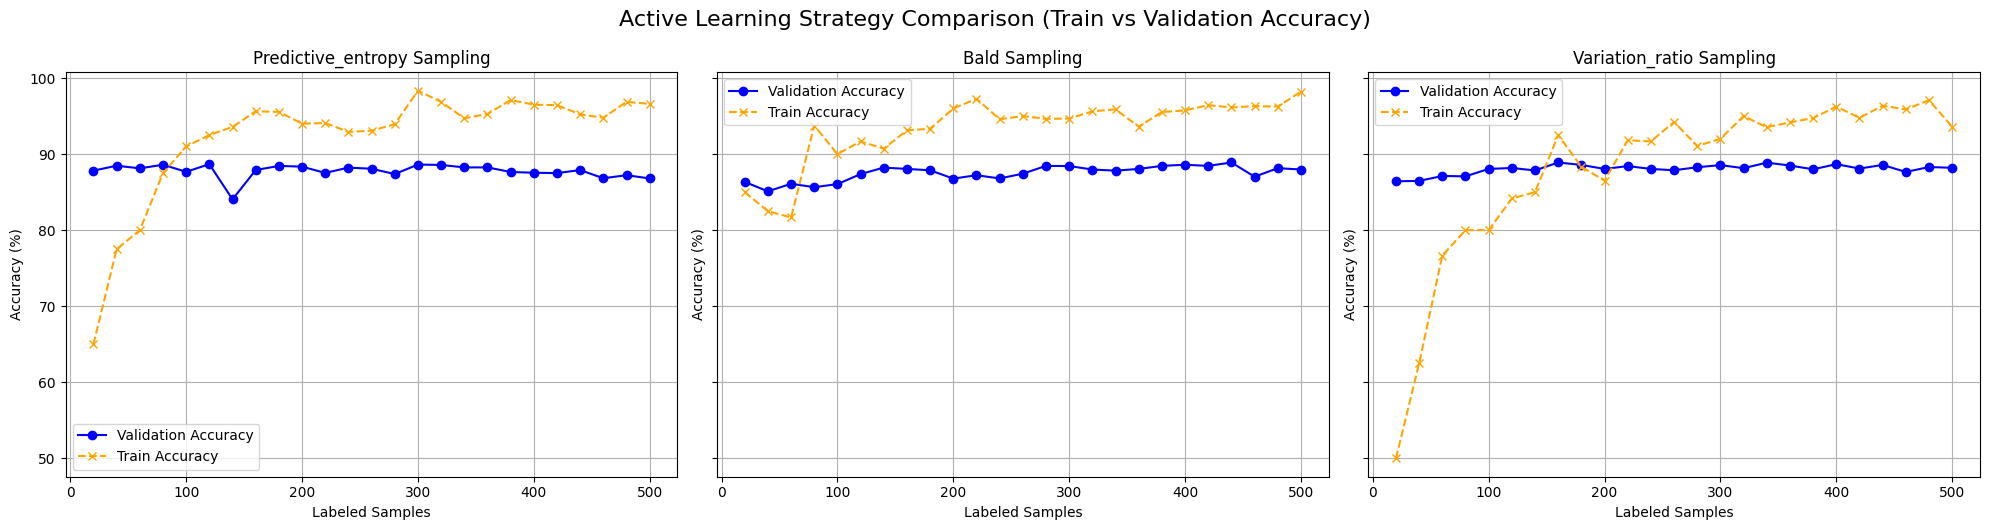

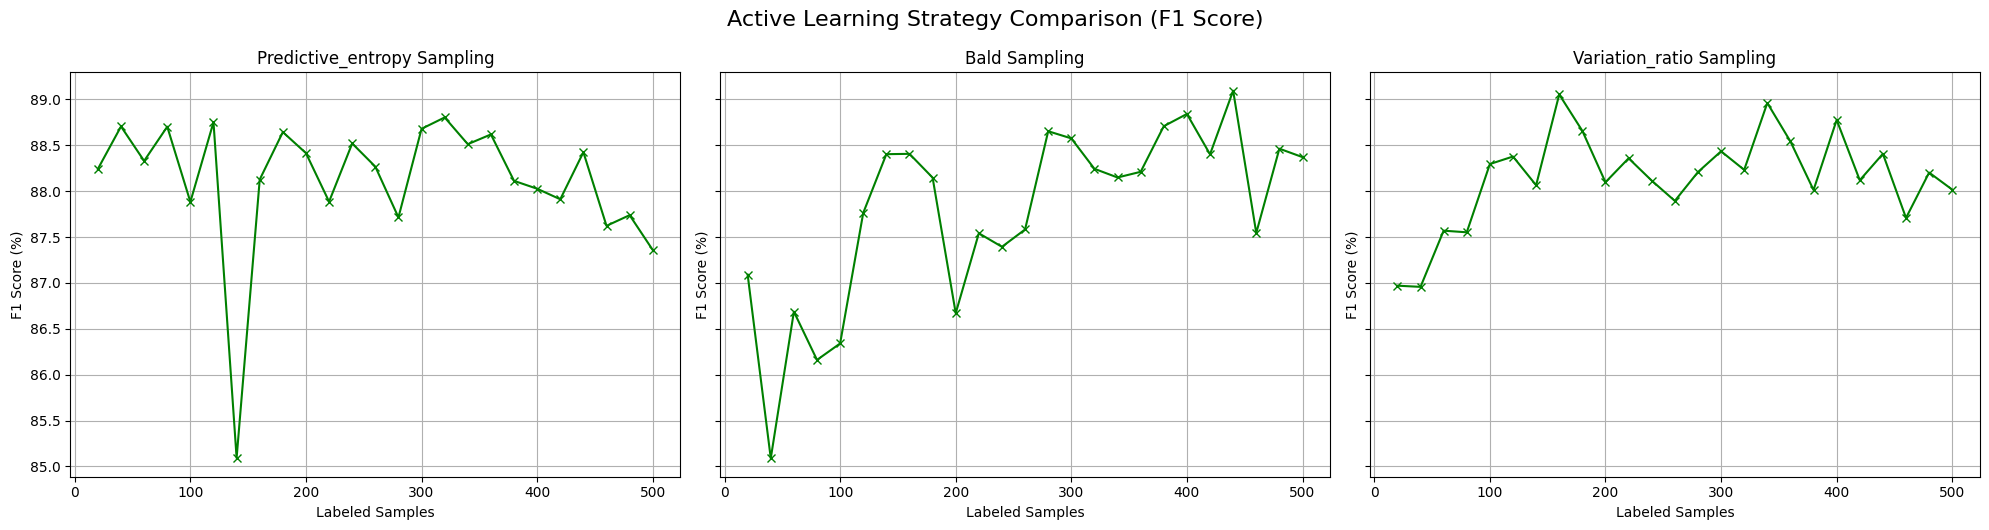

In [66]:
# Accuracy Plot: Train vs Val
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_accs = [a * 100 for a in history["val_accuracy"]]
    train_accs = [acc_list[-1] * 100 for acc_list in history["train_accuracy"]]  # last epoch of each round

    axs[i].plot(history["num_labeled"], val_accs, marker="o", label="Validation Accuracy", color="blue")
    axs[i].plot(history["num_labeled"], train_accs, marker="x", linestyle="--", label="Train Accuracy", color="orange")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Accuracy)", fontsize=16, y=1.05)
plt.show()


# Average F1 Score Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
for i, (name, history) in enumerate(strategy_histories.items()):
    axs[i].plot(history["num_labeled"], [a * 100 for a in history["val_avg_f1"]], marker="x", color='green')
    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("F1 Score (%)")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (F1 Score)", fontsize=16, y=1.05)
plt.show()

<hr>